# Install & Import

In [1]:
!pip install torchmetrics -q
!pip install fvcore -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 856.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import sys
import os
import copy
import random
import json
import math
from collections import OrderedDict
from dataclasses import dataclass
from functools import partial
from datetime import date
from prettytable import PrettyTable
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim, Tensor, ones_like, zeros_like
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from fvcore.nn import FlopCountAnalysis

import torchvision
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from torchvision.datasets import VOCSegmentation
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchsummary import summary

from fvcore.nn import FlopCountAnalysis
from torch.profiler import profile, record_function, ProfilerActivity

from typing import Any, Callable, List, Optional, Sequence, Tuple, Union, Dict
# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cpu


In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

module_dir = "/content/drive/My Drive/ShorelineNet_pytorch/"

# append local module to path
module_path = os.path.abspath(os.path.join(module_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.Bayesian_net import Bayesian_net
from model._Unet import _Unet
from model.MBConfig import MBConvConfig

from utils.bayes_func import bayes_eval, bayes_forward
from utils.train_transforms import HFlip, HueSatCon, Rotation, Crop, Affine, Resize, ToTensor, Normalize

Mounted at /content/drive/


# Load dataset

In [4]:
if 'CamVid' not in os.listdir('/content'):
  !mkdir '/content/data'
  !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/camvid.zip' '/content/data/'
  !unzip -q '/content/data/camvid.zip'

In [4]:
# get classes for CamVid
# class_dict = pd.read_csv('/content/CamVid/class_dict.csv')

RGB2CLSNAME = {
    (128, 128, 128): "Sky",

    (0, 128, 64): "Building",
    (128, 0, 0): "Building",
    (64, 192, 0): "Building",
    (64, 0, 64): "Building",
    (192, 0, 128): "Building",

    (192, 192, 128): "Pole",
    (0, 0, 64): "Pole",

    (128, 64, 128): "Road",
    (128, 0, 192): "Road",
    (192, 0, 64): "Road",

    (0, 0, 192): "Sidewalk",
    (64, 192, 128): "Sidewalk",
    (128, 128, 192): "Sidewalk",

    (128, 128, 0): "Tree",
    (192, 192, 0): "Tree",

    (192, 128, 128): "SignSymbol",
    (128, 128, 64): "SignSymbol",
    (0, 64, 64): "SignSymbol",

    (64, 64, 128): "Fence",

    (64, 0, 128): "Car",
    (64, 128, 192): "Car",
    (192, 128, 192): "Car",
    (192, 64, 128): "Car",
    (128, 64, 64): "Car",

    (64, 64, 0): "Pedestrian",
    (192, 128, 64): "Pedestrian",
    (64, 0, 192): "Pedestrian",
    (64, 128, 64): "Pedestrian",

    (0, 128, 192): "Bicyclist",
    (192, 0, 192): "Bicyclist",

    (0, 0, 0): "Void"
}


DROP_PIX: Optional[int] = None
FILL_PIX = 11

WIDTH = 480
HEIGHT = 360

CLASSES = sorted(list(set(RGB2CLSNAME.values())))
RGB2CLASS = {rgb:{c:i for i,c in enumerate(CLASSES)}[name] for (rgb, name) in RGB2CLSNAME.items()}
CLASS2RGB = {c:rgb for (rgb, c) in RGB2CLASS.items()}

CLASS_MAP_ALL={i:c for i,c in enumerate(CLASSES)}
CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
CLASS_MAP.pop(FILL_PIX)
NUM_CLASSES = len(CLASS_MAP.items())


## Transformations

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t((image, target))
        return image, target

### Training Transforms

Imported from local modules: `Flip`, `HueSatCon`, `Rotation`, `Crop`, `Affine`, `Resize`, `ToTensor`, `Normalize`

In [7]:
from torch import is_tensor

class Crop(object):
    def __init__(
        self,
        scale:Optional[Tuple[float, float]]=[1.0, 1.0],
        fill_pix: Optional[int]=FILL_PIX,
    ) -> None:
        assert(scale[1] > scale[0])
        self.fill_pix = fill_pix
        self.scale = scale

    def __call__(
        self, data: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        (x, y) = data

        h, w = y.shape[1:]
        s = random.random() * (self.scale[1] - self.scale[0]) + self.scale[0]
        h_rand = random.random()
        w_rand = random.random()

        padding = (int(w_rand*(1-s)*w),
                  int(h_rand*(1-s)*h),
                  int((1-w_rand)*(1-s)*w),
                  int((1-h_rand)*(1-s)*h))

        x_crop = transforms.Pad(padding, fill=0, padding_mode='constant')
        y_crop = transforms.Pad(padding, fill=FILL_PIX, padding_mode='constant')

        x = x_crop(x)
        y = y_crop(y)

        return (x, y)

### Test set Transforms

`Normalize_test`, `Resize_test`, all would be imported if needed

These functions only operate on images, these set of augmentations are for test images with no ground truth labels

## Dataset & Dataloader

In [11]:
class MemoryDataset(Dataset):
    def __init__(self,
                 X:Tensor,
                 y:Tensor,
                 transform:Optional[transforms.Compose]=None,
    ) -> None:
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, H, W)
        y : Tensor with shape (n, 1, H, W)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            # x, y = self.transform((x, y))
            x, y = self.transform(x, y) # to be consistent with torch
        return x, y

def get_train_transforms(intensity:float=1) -> transforms.Compose:
    '''
    Returns the transformations for the training set for given intensity
    '''
    z = intensity
    train_transforms = Compose([
      HFlip(prob=0.5),
      HueSatCon(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, prob=1),
      Crop((0.7, 1.3), fill_pix=FILL_PIX),
      # Affine(affine_percentage=0.2*z, shear_deg=0, fill_pix=FILL_PIX, prob=1),
      # Rotation(10*z, fill_pix=FILL_PIX, prob=1),
      # Crop(crop_percentage=1-z*0.2, prob=1),
      Resize((HEIGHT, WIDTH)),
      # ToTensor(),
      # RandomResizedCrop((HEIGHT, WIDTH), (0.5, 2), (1, 1)),
      Normalize(),
    ])
    return train_transforms


class DatasetManager():
  '''
  Holds dataset objects in a dict and manages augmentation properties for training set
  '''
  def __init__(self, intensity: Optional[float]=1) -> None:
    train_transforms = get_train_transforms(intensity=intensity)

    val_transforms = Compose([
        # Resize((HEIGHT, WIDTH)),
        # ToTensor(),
        Normalize(),
    ])

    test_transforms = Compose([
        # Resize_test((HEIGHT, WIDTH)),
        # ToTensor(),
        # Normalize_test()
    ])

    # train_dataset = get_train_dataset(train_transforms)
    # val_dataset = get_val_dataset(val_transforms)

    ood_dataset = load_rugd_into_memory(None)
    train_dataset = load_camvid_into_memory('train', train_transforms)
    val_dataset = load_camvid_into_memory('val', None)
    test_dataset = load_camvid_into_memory('test', None)

    self.datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset, 'ood': ood_dataset}

  def update_train_transforms(self, intensity:float=1) -> None:
    train_transforms = get_train_transforms(intensity)
    self.datasets['train'].transforms = train_transforms
    print(f'Updated training dataset augmentation intensity to {intensity}')
    return


In [22]:
# METHODS FOR CAMVID

def load_camvid_into_memory(split:str, t:transforms.Compose)->MemoryDataset:
    root_dir = '/content/CamVid'

    H, W = (480, 640) if split == 'train' else (360, 480)
    n = len(os.listdir(f'{root_dir}/{split}'))
    # preallocate tensor memory
    X = torch.zeros((n, 3, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)

    to_tensor = transforms.PILToTensor()
    resize_x = transforms.Resize((H, W), transforms.InterpolationMode.BILINEAR, antialias=True)
    resize_y = transforms.Resize((H, W), transforms.InterpolationMode.NEAREST, antialias=False)

    normalize = Normalize()

    filenames = sorted(os.listdir(f'{root_dir}/{split}'))
    for i in tqdm(range(n)):
      filename = filenames[i]
      x_path = os.path.join(root_dir, split, filename)
      y_path = os.path.join(root_dir, f'{split}_labels', filename.split('.')[0]+'_L.png')

      x = read_image(x_path).to(DEVICE)
      y = read_image(y_path).to(DEVICE)

      # x = to_tensor(x).to(torch.int8).to(DEVICE)
      y = map_rgbLabel_to_grayscale(y)

      x = resize_x(x)
      y = resize_y(y)

      x = x / 255.0
      if DROP_PIX is not None:
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      if split != 'train':
        x, y = normalize((x, y))

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)

def load_rugd_into_memory(t:transforms.Compose)->MemoryDataset:
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/RUGD_sample-data'

    H, W = (360, 480)
    n = len(os.listdir(f'{root_dir}/images'))
    # preallocate tensor memory
    X = torch.zeros((n, 3, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)

    to_tensor = transforms.PILToTensor()
    resize_x = transforms.Resize((H, W), transforms.InterpolationMode.BILINEAR, antialias=True)
    resize_y = transforms.Resize((H, W), transforms.InterpolationMode.NEAREST, antialias=False)

    normalize = Normalize()

    filenames = sorted(os.listdir(f'{root_dir}/images'))
    for i in tqdm(range(n)):
      filename = filenames[i]
      x_path = os.path.join(root_dir, 'images', filename)

      x = read_image(x_path).to(DEVICE)
      y = torch.ones((1, 1, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)

      # x = to_tensor(x).to(torch.int8).to(DEVICE)

      x = resize_x(x)

      x = x / 255.0

      x, y = normalize((x, y))

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)

def map_rgbLabel_to_grayscale(image: np.array) -> torch.Tensor:
    '''
    Takes a (3 x w x h) int8 rgb label and returns a (1 x w x h) label
    '''
    height, width = image.shape[1], image.shape[2]
    out = torch.zeros((1, height, width), dtype=torch.int, device=image.device)

    for (rgb, cls) in RGB2CLASS.items():
      boolean_array = (image[0] == rgb[0])
      boolean_array = boolean_array * (image[1] == rgb[1])
      boolean_array = boolean_array * (image[2] == rgb[2])
      out[0, boolean_array] = cls

    return out


In [26]:
# create dataset manager
dataset_manager = DatasetManager()

# create dataloaders
train_dataloader = DataLoader(dataset_manager.datasets['train'], batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_manager.datasets['val'], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset_manager.datasets['test'], batch_size=1, shuffle=True)
ood_dataloader = DataLoader(dataset_manager.datasets['ood'], batch_size=1, shuffle=True)

# # note that new instances of dataloaders are generated for every training
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader, 'ood': ood_dataloader}

### Visualization helpers

* `imshow_image`
* `imshow_label`
* `imshow_uncertainty`

In [24]:
# helper functions
from matplotlib.colors import ListedColormap
colors = [CLASS2RGB[i] for i in range(NUM_CLASSES+1)]
camvid_cmap = ListedColormap([list([c/255 for c in rgb]) for rgb in colors])

def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

def imshow_image(image):
  plt.imshow(unnormalize(image).permute(1, 2, 0).cpu())
  plt.xticks([])
  plt.yticks([])

def imshow_label(label, cmap=camvid_cmap):
  if len(label.shape) == 3:
    label = label.permute(1, 2, 0)
  elif len(label.shape) == 2:
    pass
  plt.imshow(label.cpu(), cmap=cmap, interpolation='none', vmin=0, vmax=NUM_CLASSES)
  plt.xticks([])
  plt.yticks([])

def imshow_uncertainty(uncertainty: Tensor, normalize=True):
  if normalize:
    u_max, u_min = uncertainty.max(), uncertainty.min()
    uncertainty = (uncertainty - u_min) / (u_max - u_min)
  if len(uncertainty.shape) == 3:
    uncertainty = uncertainty.permute(1, 2, 0)
  # TODO: normalize to 0 - 1?
  plt.imshow(uncertainty.cpu())
  plt.xticks([])
  plt.yticks([])

### Preview images

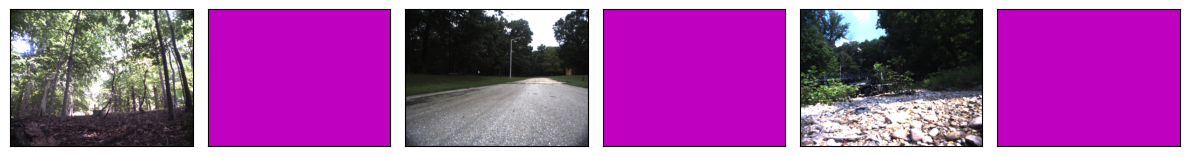

In [27]:
split = 'ood'

plt.figure(figsize=(12, 6))
for i in range(3):
  x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
  plt.subplot(1, 6, i*2+1)
  imshow_image(x_batch_sample[0])
  plt.subplot(1, 6, i*2+2)
  imshow_label(y_batch_sample[0].to(int))

# note: clipping error message can be ignored
plt.tight_layout()

In [13]:
# split = 'val'
# x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
# x, y = unnormalize(x_batch_sample[0]), y_batch_sample[0]

# flip = HFlip(prob=0.5)
# jitter = HueSatCon(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, prob=1)
# crop = Compose([Crop((0.7, 1.3), fill_pix=FILL_PIX),Resize((HEIGHT, WIDTH))])

# plt.figure(figsize=(18, 6))

# plt.subplot(2, 5, 1)
# plt.title('Original Image')
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 2)
# x, y = flip((x, y))
# plt.title('Random Flip')
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 3)
# x, y = jitter((x, y))
# plt.title('Random Jitter')
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 4)
# x, y = crop(x, y)
# plt.title('Random Crop')
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 5)
# plt.title('Label')
# imshow_label(y)

# x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
# x, y = unnormalize(x_batch_sample[0]), y_batch_sample[0]


# plt.subplot(2, 5, 1+5)
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 2+5)
# x, y = flip((x, y))
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 3+5)
# x, y = jitter((x, y))
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 4+5)
# x, y = crop(x, y)
# plt.imshow(x.permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 5, 5+5)
# imshow_label(y)

# # note: clipping error message can be ignored
# plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## Network Properties

Define some helper functions to calculate:
* parameter count
* storage
* FLOPS
* CPU/GPU run time

In [59]:
def _format_memory(nbytes):
    """Returns a formatted memory size string"""
    KB = 1024
    MB = 1024 * KB
    GB = 1024 * MB
    if abs(nbytes) >= GB:
        return f"{nbytes * 1.0 / GB:.2f} Gb"
    elif abs(nbytes) >= MB:
        return f"{nbytes * 1.0 / MB:.2f} Mb"
    elif abs(nbytes) >= KB:
        return f"{nbytes * 1.0 / KB:.2f} Kb"
    else:
        return str(nbytes) + " b"

def _format_time(time_us):
    """Defines how to format time in FunctionEvent"""
    US_IN_SECOND = 1000.0 * 1000.0
    US_IN_MS = 1000.0
    if time_us >= US_IN_SECOND:
        return f"{time_us / US_IN_SECOND:.3f}s"
    if time_us >= US_IN_MS:
        return f"{time_us / US_IN_MS:.3f}ms"
    return f"{time_us:.3f}us"

In [60]:
# helper functions for counting parameters and storage
def count_parameters(model, print_table=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if print_table:
        print(table)
    return total_params


def calculate_storage(model, print_buffer=True):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    if print_buffer:
        print(f"Buffer size: {buffer_size/1024**2:.3f} MB")

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb


In [61]:
def count_FLOPS(net: nn.Module) -> float:
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, 'all')
    flops = FlopCountAnalysis(net, x_batch).total()

  # print(f'Flops: {flops.total()/1e9:.3f} G')
  return flops

In [62]:
def compute_cpu_runtime_memory(net: nn.Module, n:Optional[int]=5) -> Tuple[float, float]:
  '''
  Computes the cpu and gpu run time in ms
  Returns
  -----------
  runtimes: Array[float], cpu runtime in ms
  memories: Array[float], cpu memory in mb
  '''
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to('cpu')
  # MEMORY & INFERENCE TIME
  net.to('cpu')
  x_batch = x_batch.to('cpu')

  runtimes, memories = [], []

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(False, 'all')
    for _ in tqdm(range(n)):
      with profile(activities=[ProfilerActivity.CPU],
                  profile_memory=True,
                  record_shapes=False) as prof:
        with record_function("model_inference"):
          net(x_batch)
          # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')
      for event in prof.key_averages():
        if event.key == 'model_inference':
          runtimes.append(event.cpu_time/1000)
        if event.key == 'aten::empty':
          memories.append(event.cpu_memory_usage/1024/1024)

  runtimes, memories = np.array(runtimes), np.array(memories)

  return runtimes, memories



In [63]:
def compute_gpu_runtime_memory(net: nn.Module, n:Optional[int]=5, debug=False, k=0) -> Tuple[float, float]:
  '''
  Computes the gpu run time in ms
  Returns
  -----------
  runtimes: Array[float], cpu runtime in ms
  memories: Array[float], cpu memory in mb
  '''
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
  # MEMORY & INFERENCE TIME
  net.to(DEVICE)
  x_batch = x_batch.to(DEVICE)

  runtimes, memories = [], []

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(False, 'all')
    for _ in tqdm(range(n)):
      with profile(activities=[ProfilerActivity.CPU,ProfilerActivity.CUDA],
                  profile_memory=True,
                  record_shapes=False) as prof:
        with record_function("model_inference"):
          if k == 0:
            net(x_batch)
          else:
            bayes_eval(net, x_batch.squeeze(0), k=k, mode='all')
      for event in prof.key_averages():
        if event.key == 'model_inference':
          runtimes.append(event.cuda_time/1000)
        if event.key == 'aten::empty':
          memories.append(event.cuda_memory_usage/1024/1024)

  runtimes, memories = np.array(runtimes), np.array(memories)

  if debug:
    return prof

  return runtimes, memories


In [64]:
# # MEMORY & INFERENCE TIME
# net.to('cpu')
# x_batch = x_batch.to('cpu')
# with profile(activities=[
#         ProfilerActivity.CPU], profile_memory=True, record_shapes=False) as prof:
#     net.eval()
#     net.set_bayes_mode(False, 'all')
#     with record_function("model_inference"):
#         net(x_batch)
#         # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')


In [65]:
# for event in prof.key_averages():
#   if event.key == 'model_inference':
#     print(event)
#     print(f'CPU time: {event.cpu_time/1000}ms')
#   if event.key == 'aten::empty':
#     print(event)
#     print(f'cpu memory: {event.cpu_memory_usage/1024/1024}Mb')

## UNet

### Deconv Variations

In [66]:
class Deconv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        layers: List[nn.Module] = []

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                cfg.input_channels,
                cfg.out_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        return result

In [67]:
class Dw_deconv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        layers: List[nn.Module] = []

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                cfg.input_channels,
                cfg.input_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                groups=cfg.input_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        # project
        layers.append(
            Conv2dNormActivation(
                cfg.input_channels,
                cfg.out_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=None,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        return result

### Network Config
Configuration for efficientnet and mobilenet

In [68]:
def _efficientnet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 5, 2, 24, 40, 2, 0, 1),
        bneck_conf(6, 3, 2, 40, 80, 3, 0, 0),
        bneck_conf(6, 5, 1, 80, 112, 3, 0.5, 1),
        bneck_conf(6, 5, 2, 112, 192, 4, 0.5, 0),
        bneck_conf(6, 3, 1, 192, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting


def _mobilenet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 3, 2, 24, 32, 3, 0, 1),
        bneck_conf(6, 3, 2, 32, 64, 4, 0, 0),
        bneck_conf(6, 3, 1, 64, 96, 3, 0.5, 1),
        bneck_conf(6, 3, 2, 96, 160, 3, 0.5, 0),
        bneck_conf(6, 3, 1, 160, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting

network_scales = {
    "regularDecoder": (1.0, 1.0, 224),
    "mobilenet-dw": (1.0, 1.0, 224),
    "efficientnet-b0": (1.0, 1.0, 224),
    "efficientnet-b1": (1.0, 1.1, 240),
    "efficientnet-b2": (1.1, 1.2, 260),
    "efficientnet-b3": (1.2, 1.4, 300),
    "efficientnet-b4": (1.4, 1.8, 380),
    "efficientnet-b5": (1.6, 2.2, 456),
    "efficientnet-b6": (1.8, 2.6, 528),
    "efficientnet-b7": (2.0, 3.1, 600),
    "mobilenet-v2": (1.0, 1.0, 224),
    "efficientnet-b0-hswish": (1.0, 1.0, 224),
}

network_cfgs = {
    "regularDecoder": _mobilenet_cfg,
    "mobilenet-dw": _mobilenet_cfg,
    "efficientnet-b0": _efficientnet_cfg,
    "efficientnet-b1": _efficientnet_cfg,
    "efficientnet-b2": _efficientnet_cfg,
    "efficientnet-b3": _efficientnet_cfg,
    "efficientnet-b4": _efficientnet_cfg,
    "efficientnet-b5": _efficientnet_cfg,
    "efficientnet-b6": _efficientnet_cfg,
    "efficientnet-b7": _efficientnet_cfg,
    "mobilenet-v2": _mobilenet_cfg,
    "efficientnet-b0-hswish": _efficientnet_cfg,
}

### Unet

Wrapper class for building the network for a given configuration


In [69]:
class Unet(_Unet):
    def __init__(
        self,
        encoder_name: str = "efficientnet-b0",
        input_dim: Optional[Union[int, Tuple[int, int]]] = None,
        width_mult: Optional[float] = None,
        depth_mult: Optional[float] = None,
        stochastic_depth_prob: float = 0.2,
        use_se: Optional[bool] = False,
        dropout_p: float = 0.5,
        num_classes: int = 3,
        last_channel: Optional[int] = None,  # set 0 to disable, None for 4x
        skip_mode: Optional[str] = "upsample",  # "upsample", "none", "all"
        skip_op: Optional[str] = "concat",  # "concat", "add"
        shallowDeconv: Optional[bool] = False,
        dropout_loc: Optional[str] = None,  # "last", "middle"
        constant_dropout: Optional[bool] = True,
    ) -> None:
        assert (
            encoder_name in network_cfgs.keys()
        ), f"invalid encoder_name mode {encoder_name}"

        assert skip_mode in [
            "upsample",
            "none",
            "all",
        ], f"invalid skip loc {skip_mode}"

        assert skip_op in ["concat", "add"], f"invalid skip mode {skip_op}"

        assert dropout_loc in [
            "last",
            "middle",
            None,
        ], f"invalid dropout location {dropout_loc}"

        def set_layer_dropout(cfg, constant_dropout, dropout_p) -> None:
            total_layers = len(cfg)
            for i, layer in enumerate(cfg):
                if constant_dropout:
                    layer.dropout_p = dropout_p if layer.dropout_p > 0 else 0
                else:
                    # linearly interpolate the dropout rate
                    layer.dropout_p = dropout_p * i / (total_layers - 1)

        def set_dropout(cfg, dropout_loc, dropout_p, constant_dropout=False):
            total_layers = len(cfg)

            if dropout_loc == "middle":
                # enable dropout in the middle of the network
                for i in range(total_layers - 1):
                    cfg[i].dropout_p = 0
                cfg[-1].dropout_p = dropout_p
            elif dropout_loc == "last":
                # turn off all dropout
                for layer in cfg:
                    layer.dropout_p = 0
            elif dropout_loc == "all":
                for layer in cfg:
                    layer.dropout_p = 1
            else:
                set_layer_dropout(cfg, constant_dropout, dropout_p)

        d = network_scales[encoder_name][2] if not input_dim else input_dim
        width_mult = network_scales[encoder_name][0] if not width_mult else width_mult
        depth_mult = network_scales[encoder_name][1] if not depth_mult else depth_mult
        cfg = network_cfgs[encoder_name](width_mult, depth_mult)

        if encoder_name.startswith("efficientnet"):
            use_se = True if use_se is None else use_se
            activation_layer = nn.SiLU
            if encoder_name == "efficientnet-b0-hswish":
                activation_layer = nn.Hardswish
        elif encoder_name.startswith("mobilenet"):
            use_se = False if use_se is None else use_se
            activation_layer = nn.ReLU
        elif encoder_name in ["regularDecoder", "mobilenet-dw"]:
            use_se = False
            activation_layer = nn.ReLU
        else:
            raise NotImplementedError

        # ---------- Modify Skip & Dropout ------------
        if skip_mode != "upsample":
            # overwrite default skip connections
            for i in range(len(cfg) - 1):
                cfg[i].use_skip = True if skip_mode == "all" else False

        set_dropout(cfg, dropout_loc, dropout_p, constant_dropout)
        last_dropout_p = dropout_p if dropout_loc == "last" else 0

        # ---------- Build Decoder Config ------------
        decoder_cfg = self._decoder_config(cfg, skip_op)
        if shallowDeconv:
            self._set_cfg_shallow(decoder_cfg)
        # modify decoder block
        if encoder_name == "regularDecoder":
            self._set_decoder_block(decoder_cfg, Deconv)
        elif encoder_name == "mobilenet-dw":
            self._set_decoder_block(decoder_cfg, Dw_deconv)

        super().__init__(
            encoder_cfg=cfg,
            decoder_cfg=decoder_cfg,
            input_dim=d,
            stochastic_depth_prob=stochastic_depth_prob,
            num_classes=num_classes,
            last_channel=last_channel,
            skip_mode=skip_op,
            use_se=use_se,
            activation_layer=activation_layer,
            # shallowDeconv=shallowDeconv,
            last_dropout_p=last_dropout_p,
        )

    def _set_decoder_block(self, decoder_cfg, block):
        for i, cfg in enumerate(decoder_cfg):
            decoder_cfg[i].block = block

    def _decoder_config(self, encoder_cfg, skip_op: str) -> List[MBConvConfig]:
        decoder_cfg: List[MBConvConfig] = []
        oup = encoder_cfg[0].input_channels
        skip = 0
        prev_n=1
        for (i, cfg) in enumerate(encoder_cfg):

            skip = cfg.out_channels if cfg.use_skip else 0
            cfg_copy = copy.copy(cfg)
            cfg_copy.input_channels = cfg.out_channels
            if skip_op == "concat":
                cfg_copy.input_channels += skip
            cfg_copy.out_channels = oup

            temp_n = cfg.num_layers
            cfg_copy.num_layers = prev_n
            prev_n = temp_n

            decoder_cfg.append(cfg_copy)

            oup = cfg.out_channels

        # decoder_cfg[-1].expand_ratio = 3

        return decoder_cfg[::-1]

    def _set_cfg_shallow(self, setting):
        # set n for decoder to be all 1
        for cfg in setting:
            cfg.num_layers = 1

## network instantiation

In [70]:
# net_name = "regularDecoder"
net_name = "mobilenet-dw"
net_name = "mobilenet-v2"
# net_name = "efficientnet-b0"

net = Unet(net_name,
           input_dim=(HEIGHT, WIDTH),
           width_mult=1,
           depth_mult=1,
           dropout_p=0.3,
           constant_dropout=False,
           stochastic_depth_prob=0,
           use_se=False,
           num_classes=NUM_CLASSES,
           last_channel=0,
           shallowDeconv=False,
           dropout_loc=None,
           skip_mode='upsample',
           skip_op='concat')

print("----UNET----")
size_all_mb = calculate_storage(net)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net)
print(f"Total Trainable Params: {total_params/1e6 :.3f}M")

net.to(DEVICE)
print(f'moved network to {DEVICE}')

----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
moved network to cuda:0


In [71]:
# runtimes, memories = compute_cpu_runtime_memory(net, n=5)

# print(f'Runtime: {runtimes.mean():.2f}ms +- {runtimes.std():.2f}')
# print(f'Memory: {memories.mean():.2f}Mb +- {memories.std():.2f}')

# Runtime: 416.07ms +- 53.25
# Memory: 372.54ms +- 2.28

In [72]:
# runtimes, memories = compute_gpu_runtime_memory(net, n=5)

# print(f'Runtime: {runtimes.mean():.2f}ms +- {runtimes.std():.2f}')
# print(f'Memory: {memories.mean():.2f}Mb +- {memories.std():.2f}')

# Inverted Residual
# model size: 14.237MB
# Total Trainable Params: 3.669M
# Runtime: 11.49ms +- 0.01
# Memory: 179.39Mb +- 0.00

# Inverted Residual (0.75)
# model size: 8.021MB
# Total Trainable Params: 2.057M
# Runtime: 10.57ms +- 0.01
# Memory: 156.60Mb +- 0.00
# 51

# with SE
# model size: 17.651MB
# Total Trainable Params: 4.565M
# Runtime: 14.03ms +- 0.01
# Memory: 179.13Mb +- 0.00
# 52

# Depth-wise
# model size: 7.789MB
# Total Trainable Params: 2.004M
# Runtime: 7.89ms +- 0.01
# Memory: 125.83Mb +- 0.07
# 50

# Regular:
# model size: 12.857MB
# Total Trainable Params: 3.336M
# Runtime: 8.03ms +- 0.01
# Memory: 102.00Mb +- 0.00
# 48

In [73]:
# FLOPS

# from fvcore.nn import FlopCountAnalysis

# x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
# flops = FlopCountAnalysis(net, x_batch)

# print(f'Flops: {flops.total()/1e9:.3f} G')


In [74]:
# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

### Dummy pass to see initial outputs

In [75]:
# x_batch_sample, y_batch_sample = next(iter(test_dataloader))

# # net = net
# # net = training_manager.net

# with torch.no_grad():
#   net.eval()
#   net.set_bayes_mode(False, 'all')
#   plt.subplot(1, 3, 1)
#   plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
#   plt.axis('off')

#   plt.subplot(1, 3, 2)
#   imshow_label(y_batch_sample[0])
#   plt.axis('off')
#   net.train()

#   pred = net(x_batch_sample.to(DEVICE))
#   plt.subplot(1, 3, 3)
#   imshow_label(torch.argmax(pred[0], dim=0))
#   plt.axis('off')
#   net.train()

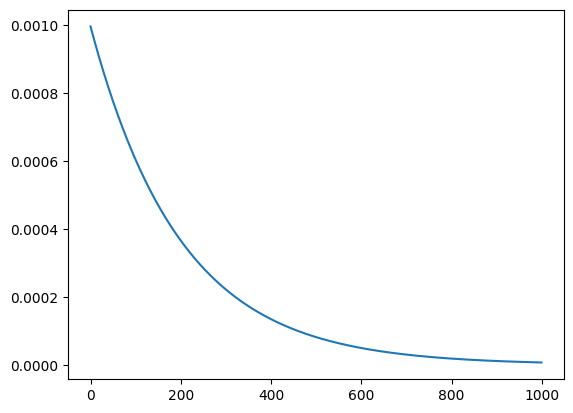

In [76]:
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
# # scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=10000, power=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

lrs = []
for _ in range(1000):
  scheduler.step()
  # lr = optimizer.param_groups[0]['lr']
  lrs.append(scheduler.get_last_lr())


plt.plot(lrs)

# plt.plot([(1-(i+1)/100)**0.9*1e-3 for i in range(100)])

In [77]:
# batch = 5
# iterations = 5000
# training_size = 367

# epochs = iterations / math.ceil(training_size / batch)
# print(epochs)

# epochs = 300
# iterations = epochs * math.ceil(training_size / batch)
# print(iterations)

In [78]:
del(net)

## Loss

In [79]:
class FocalLoss(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    # place mask over placeholder pixels (loss do not propagate through them)
    mask = torch.where(y_true == FILL_PIX, zeros_like(y_true), ones_like(y_true))

    y_true = (y_true * mask).squeeze(dim=1)
    # one-hot encode labels
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=NUM_CLASSES).float().permute(0, 3, 1, 2)

    y_pred = y_pred * mask
    focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (focal_loss * mask).sum() / (mask.sum()+1e-16)

    return loss

class CELoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    return loss


## Metric

In [80]:
# TODO: DICE accuracy

### Raw pixel accuracy

In [81]:
class AccuracyMetric_archived(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    metrics = {}

    ious = self.iou(y_pred_softmax, y_true.squeeze(dim=1))
    for i, c in CLASS_MAP.items():
      metrics[f'iou/{c}'] = ious[i]
    # metrics['iou/mean'] = ious.mean()

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      metrics[f'acc/{c}'] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in metrics.values():
      avg_accuracy += a
    # metrics['acc/avg'] = avg_accuracy / len(metrics.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    metrics['acc/global'] = (diff*mask).sum() / mask.sum()

    return metrics


### IOU

In [82]:
class IOUMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class and mean IOUs
    '''
    out = {}
    ious = self.iou(y_pred_softmax, y_true)
    for i, c in CLASS_MAP.items():
      out[c] = ious[i]
    out['mean'] = ious.mean()
    return out

## Confusion Matrix

In [83]:
class AccuracyMetric(object):
  def __init__(self):
    pass

  def __call__(self, confusion_matrix:Tensor)->dict:
    '''
    Args
    ---------
    confusion_matrix: Tensor (c x c)
    n: int
    '''
    cm = confusion_matrix
    metrics = {}

    TPs = torch.diagonal(cm, 0)
    FPs = torch.sum(cm, dim=0) - TPs
    FNs = torch.sum(cm, dim=1) - TPs

    accs = TPs / (TPs + FNs)

    ious = TPs / (FNs + FPs + TPs)

    avg_acc = accs.mean()
    miou = ious.mean()

    for c in range(NUM_CLASSES):
      metrics[f'iou/{CLASS_MAP[c]}'] = ious[c].item()
    metrics['iou/mean'] = miou.item()

    for c in range(NUM_CLASSES):
      metrics[f'acc/{CLASS_MAP[c]}'] = accs[c].item()
    metrics['acc/avg'] = avg_acc.item()
    metrics['acc/global'] = TPs.sum().item() / (cm.sum().item() + 1e-16)

    return metrics


def get_confusion_matrix(y_gt: Tensor, y_pred: Tensor, num_classes: int) -> Tensor:
  """
  Compute the bins to update the confusion matrix with, code adapted from torchmetrics
  Args
  ----------
  y_gt: torch.tensor (n, 1, 224, 224)
  y_pred: torch.tensor (n, 1, 224, 224)
  num_classes: int

  Returns
  ----------
  confusion_matrix: torch.tensor(num_classes, num_classes)
  """

  unique_mapping = y_gt.to(torch.long) * num_classes + y_pred.to(torch.long)
  bins = torch.bincount(unique_mapping.flatten(), minlength=num_classes*(num_classes+1))
  # print(bins)
  # print(bins.reshape(12, 11))
  # print(bins.reshape(12, 11)[0, :])

  return bins[:num_classes**2].reshape(num_classes, num_classes)


In [84]:
def count_classes(y_gt: Tensor) -> Dict[str, int]:
  '''
  Returns a dictionary containing counts of whether classes appear in image

  Args
  ----------
  y_gt: torch.tensor (n, 1, 224, 224)
  '''
  out = {c: 0 for c in CLASS_MAP.values()}

  for y in y_gt:
    for i, c in CLASS_MAP.items():
       if i in y_gt:
        out[c] += 1

  return out

In [85]:
def calibrate_accs(accs, counts, m) -> Dict[str, int]:
  '''
  computes the proper per-class accuracy and ious based on counts, along with MIOU and avg acc
  '''
  # print(counts)
  total_ious, total_accs = 0, 0
  for c, n in counts.items():
    accs[f'iou/{c}'] = accs[f'iou/{c}'].item() / (n + 1e-16)
    total_ious += accs[f'iou/{c}']

    accs[f'acc/{c}'] = accs[f'acc/{c}'].item() / (n + 1e-16)
    total_accs += accs[f'acc/{c}']

  accs['iou/mean'] = total_ious / NUM_CLASSES
  accs['acc/avg'] = total_accs / NUM_CLASSES
  accs['acc/global'] = accs['acc/global'].item() / m

  return accs


In [86]:
# xs, ys = next(iter(dataloaders['train']))

# print(xs.shape)
# print(ys.shape)
# old_metric = AccuracyMetric_archived()
# metric = Accuracy_metric()

# y_logit = training_manager.net(xs)
# y_pred = torch.argmax(y_logit, 1, keepdim=True)
# old_scores = old_metric(ys, y_logit)

# unique_mapping = ys.to(torch.long) * NUM_CLASSES + y_pred.to(torch.long)
# bins = torch.bincount(unique_mapping.flatten(), minlength=NUM_CLASSES*(NUM_CLASSES+1))

# cm = get_confusion_matrix(ys, y_pred, NUM_CLASSES)
# new_scores = metric(cm, xs.shape[0])

# new_scores

# Bayesian Functions

## Bayes Forward
Imported from local modules

    Performs k forward passes with stochastic regularisation

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor (k x c x W x H) buffer

    Returns
    -----------
    y_softmax            : torch.tensor (c x W x H)
    y_pred               : torch.tensor (W x H)
    y_pred_std_per_class : torch.tensor (c x W x H)
    y_pred_std_avg       : torch.tensor (W x H)

## Bayes Evaluation Pass

Only outputs the final predictions, used for inference on test set & saves some computation

    Performs k forward passes with dropout layers, returns prediction

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor(k x c x W x H) buffer

    Returns
    -----------
    y_pred               : torch.tensor (W x H)

## Calibration

In [87]:
def compute_calibration_statistics(total_counts, total_corrects, confs):
  '''
  Computes the calibration statistics given the buckets
  '''
  num_buckets = len(total_counts)
  n = total_counts.sum()

  step = 1/num_buckets

  ECE = 0
  MCE = 0

  for i in range(num_buckets):
    conf = confs[i]
    acc = total_corrects[i]/total_counts[i]
    calibration_error = total_counts[i] * np.absolute(conf - acc)

    ECE += calibration_error / n
    MCE = max(calibration_error / n, MCE)

  return ECE, MCE

In [88]:
def get_calibration(net:nn.Module,
                    dataloader:DataLoader,
                    k:int,
                    mode: Optional[str]='all',
                    num_buckets:Optional[int]=10
):
  '''
  Returns array of buckets for the reliability plot

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  mode: sets the mode of which bayesian inference to perform
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  Returns
  -----------
  total_counts: (num_buckets, ) np array, number of instances with confidence in the bucket
  total_corrects: (num_buckets, ) np array, number of correct instances with confidence in the bucket
  total_confs: (num_buckets, ) np array, the confidence score for each bucket by the network
  '''
  total_counts = np.array([1e-16]*num_buckets, dtype=np.float32)
  total_corrects = np.array([0]*num_buckets, dtype=np.float32)
  total_confs = np.array([0]*num_buckets, dtype=np.float32)

  # loop through images and make predictions
  for X_batch, y_batch in tqdm(dataloader):
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
        elif k > 0:
          net.set_bayes_mode(True, mode)
          y_softmax, _, _, _ = bayes_forward(net, x, k)

        counts, corrects, conf = get_calibration_per_prediction(y, y_softmax, num_buckets)
        total_counts += counts
        total_corrects += corrects
        total_confs += conf

  # buckets = total_corrects / total_counts

  return total_counts, total_corrects, total_confs/total_counts

def get_calibration_per_prediction(y_gt, y_softmax, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x W x H)
  y_softmax: torch.tensor (c x W x H)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, ) counts in each bin
  correct: np.array (num_buckets, ) number of corrects in each bin
  conf: np.array (num_buckets, ) the average confidence p
  '''
  mask = (y_gt!=FILL_PIX).to(float)
  out_count = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  out_correct = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  out_conf = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  step = 1/num_buckets
  # get probability and prediction
  y_prob, y_pred = torch.max(y_softmax, dim=0)
  indices = y_prob // step

  for i in range(num_buckets):
    idx_mask = mask*(indices==i)
    out_count[i] = (idx_mask).sum()
    out_correct[i] = (idx_mask*(y_pred==y_gt)).sum()
    out_conf[i] = (idx_mask*y_prob).sum().item()
  return out_count, out_correct, out_conf


## Epistemic & Aleatoric Uncertainties

In [89]:
def compute_bayesian_uncertainties(net, X:Tensor, k:int, mode:Optional[str]='all')->Tuple[Tensor, Tensor]:
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x W x H), a single input image
  k  : int, indicating number of repeated forwards passes
  mode: str, indicating what mode of bayesian inference to do

  Returns
  -----------
  predictive_entropy: torch.tensor (W x H)
  mutual_information: torch.tensor (W x H)
  y_pred: torch.tensor (W x H)
  '''
  assert (k>=1)

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, mode)
    # write image to buffer
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
    for i in range(k):
      buffer[i] = X

    eps = 1e-8
    y_logits = net(buffer)
    y_softmax = y_logits.softmax(dim=1) # k x c x W x H
    avg_over_k = y_softmax.mean(dim=0) # c x W x H
    predictive_entropy = -(avg_over_k * torch.log(avg_over_k+eps)).sum(dim=0) # W x H
    mutual_information = predictive_entropy + 1/k * (y_softmax*torch.log(y_softmax+eps)).sum(dim=0).sum(dim=0) # W x H

    epistemic_uncertainty = mutual_information
    aleatoric_uncertainty = predictive_entropy - epistemic_uncertainty

    y_pred = torch.argmax(avg_over_k, dim=0)

  return predictive_entropy, mutual_information, y_pred

## PAvPU

In [90]:
def PAvPU(gt: Tensor,
          pred: Tensor,
          uncertainty: Tensor,
          min_uncertainty: float,
          max_uncertainty: float,
          acc_threshold: Optional[float]=0.5,
          window: Optional[int]=4,
          num_buckets=100)->float:
  '''
  Computes PAvPU for a single image
  Args
  --------
  gt: Tensor (1 x w x h)
  pred: Tensor (1 x w x h)
  uncertainty: Tensor (1 x w x h)
  acc_threshold: float indicating threshold for correct/wrong
  window: slider size
  Returns
  --------
  pa: List[float] P(accurate|certain)
  pu: List[float] P(inaccurate|uncertain)
  PAvPU: List[float]
  '''

  pas, pus, pavpus = [], [], []


  def compute_pavpu(a, mask, percentage_certain, p_threshold):
    c = (percentage_certain < p_threshold).to(float)
    u = (percentage_certain >= p_threshold).to(float)

    nac = (a * c * mask).sum()
    nic = ((1-a) * c * mask).sum()
    niu = ((1-a) * (1-c) * mask).sum()
    nau = (a * (1-c) * mask).sum()

    pa = nac/(nac + nic + 1e-16)
    pu = niu/(nic + niu + 1e-16)

    pavpu = (nac + niu) / (nac + nau + nic + niu + 1e-16)

    return pa.item(), pu.item(), pavpu.item()

  sum_pool = nn.AvgPool2d(kernel_size=window, stride=window, divisor_override=1)

  # valid pixels
  mask = (gt!=FILL_PIX).to(float)
  # indicates no. of "active pixels" in the pooled dimension
  active_pixels = (sum_pool(mask).to(float))

  # turn off outputs on invalid pixels so they don't count towards the sum
  corrects = (pred==gt)*mask.to(float)
  uncertainty = (uncertainty*mask).to(float)

  norm_factor = uncertainty.sum()

  # compute average per patch
  percentage_correct = sum_pool(corrects) / (active_pixels+1e-16)
  percentage_certain = sum_pool(uncertainty) / (active_pixels+1e-16)

  # percentage_certain /= norm_factor

  a = (percentage_correct >= acc_threshold).to(int)
  i = (percentage_correct == acc_threshold).to(int)

  # indicates patches with no valid pixels
  binary_mask = (active_pixels!=0).to(int)
  # print(binary_mask.sum())

  for n in range(num_buckets):
    step = n * 1/num_buckets

    # max_uncertainty, min_uncertainty = percentage_certain.max(), percentage_certain.min()

    uncertainty_threshold = min_uncertainty + step * (max_uncertainty - min_uncertainty)
    # uncertainty_threshold = step

    pa, pu, pavpu = compute_pavpu(a, binary_mask, percentage_certain, uncertainty_threshold)

    pas.append(pa)
    pus.append(pu)
    pavpus.append(pavpu)

  return pas, pus, pavpus



In [91]:
def compute_average_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
)->Tuple[float, float, float]:

  if not dataloader:
    dataloader = val_dataloader

  avg_wa_p, avg_entropy, avg_mutual_info = 0, 0, 0
  with torch.no_grad():
    for X_batch, y_batch in tqdm(dataloader):
      # force loop to be over single images
        for (x, y) in zip(X_batch, y_batch):
          mask = (y!=FILL_PIX).to(float) # (w x h)
          # mask = torch.ones_like(y).to(float)

          # normal forward pass
          net.eval()
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
          # compute entropy (adjusted by fill pix)
          entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) * mask # (w x h)
          avg_wa_p += entropy.sum() / (mask.sum() + 1e-16)

          # bayes pass
          net.eval()
          net.set_bayes_mode(True, 'all')

          entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')
          # buffer = x.unsqueeze(0).repeat(k, 1, 1, 1) # (k x 3 x w x h)
          # # softmax averaged across k forward passes
          # y_softmax = net(buffer).softmax(dim=1).mean(dim=0) # (11 x w x h)
          # # compute entropy (adjusted by fill pix)
          # entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) * mask # (w x h)
          # print(y_softmax)
          entropy = entropy * mask
          mutual_info = mutual_info * mask

          avg_entropy += entropy.sum() / (mask.sum() + 1e-16)
          avg_mutual_info += mutual_info.sum() / (mask.sum() + 1e-16)

  avg_wa_p = avg_wa_p / len(dataloader.dataset)
  avg_entropy = avg_entropy / len(dataloader.dataset)
  avg_mutual_info = avg_mutual_info / len(dataloader.dataset)

  return avg_wa_p.item(), avg_entropy.item(), avg_mutual_info.item()


In [92]:
def compute_min_max_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
) -> Dict[str, Tuple[float, float]]:
    if not dataloader:
      dataloader = val_dataloader

    output = {'wa': [np.inf, -np.inf],
              'PE': [np.inf, -np.inf],
              'MI': [np.inf, -np.inf],}

    def parse_min(tensor, mask):
        return torch.where(mask == 1, tensor, torch.inf).min()

    def parse_max(tensor, mask):
        return torch.where(mask == 1, tensor, -torch.inf).max()

    with torch.no_grad():
      for X_batch, y_batch in tqdm(dataloader):
        # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            mask = (y!=FILL_PIX).to(float) # (w x h)

            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
            # compute entropy (adjusted by fill pix)
            entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) # (w x h)

            output['wa'][0] = min(output['wa'][0], parse_min(entropy, mask))
            output['wa'][1] = max(output['wa'][1], parse_max(entropy, mask))

            # bayes pass
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')

            output['PE'][0] = min(output['PE'][0], parse_min(entropy, mask))
            output['PE'][1] = max(output['PE'][1], parse_max(entropy, mask))
            output['MI'][0] = min(output['MI'][0], parse_min(mutual_info, mask))
            output['MI'][1] = max(output['MI'][1], parse_max(mutual_info, mask))

      return output


In [93]:
def compute_mean_std_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
) -> Dict[str, Tuple[float, float]]:
    if not dataloader:
      dataloader = val_dataloader
    #                x  x^2
    track  = {'wa': [0, 0],
              'PE': [0, 0],
              'MI': [0, 0],}

    with torch.no_grad():
      for X_batch, y_batch in tqdm(dataloader):
        # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            mask = (y!=FILL_PIX).to(float) # (w x h)

            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
            # compute entropy (adjusted by fill pix)
            entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) # (w x h)

            output['wa'][0] += (entropy * mask).sum()
            output['wa'][1] += (entropy **2 * mask).sum()

            # bayes pass
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')

            output['PE'][0] = (entropy * mask).sum()
            output['PE'][1] = (entropy **2 * mask).sum()
            output['MI'][0] = (mutual_info * mask).sum()
            output['MI'][1] = (mutual_info **2 * mask).sum()

      n = len(dataloader.dataset)
      output = {}
      for k, (x, x2) in track.items():
        output[k] = [x/n, (x2/n - (x/n)**2)**0.5]

      return output

In [94]:
def compute_auc(ys, xrange:Optional[int]=1):
  n = len(ys)
  step = xrange/n

  auc = 0
  prev = ys[0]
  for i in range(n):
    curr = ys[i]
    area = (curr+prev)/2 * step
    auc += area
    prev = curr

  return auc

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [95]:
class TrainingManager():
  def __init__(self, datasets, config):
    self.datasets = datasets
    self.config = config

    self._load()
    # self.net = copy.deepcopy(net).to(DEVICE) # no longer importing net

  def _load(self):
    # hyperparameters from config
    self.batch_size = self.config.get('batch_size', 16)
    self.total_epochs = self.config.get('total_epochs', 100)
    self.weight_decay = self.config.get('weight_decay', 1e-4)
    self.lr = self.config.get('lr', 1e-4)
    self.k = self.config.get('k', 10)
    self.patience = self.config.get('patience', 20)
    self.track_metrics = self.config.get('track_metrics', ['loss'])
    self.num_classes = self.config.get('num_classes', 3)
    self.bayes_mode = self.config.get('bayes_mode', 'all')
    self.eval_subset = self.config.get('eval_subset', None)


    # initiate dataloader
    self.dataloaders = {'train': DataLoader(self.datasets['train'], batch_size=self.batch_size, shuffle=True),
                        'val': DataLoader(self.datasets['val'], batch_size=1, shuffle=True),
                        'test': DataLoader(self.datasets['test'], batch_size=1, shuffle=False)}

    # initiate net
    self.net = Unet(encoder_name=self.config['model'],
                    num_classes=self.config['num_classes'],
                    width_mult=self.config.get('width_mult', None),
                    depth_mult=self.config.get('depth_mult', None),
                    input_dim=self.config['input_dim'],
                    stochastic_depth_prob=self.config['stochastic_depth_prob'],
                    use_se=self.config.get('use_se', None),
                    dropout_p=self.config['dropout_p'],
                    constant_dropout = self.config['dropout_mode'] == 'constant',
                    last_channel=self.config.get('last_channel', None),
                    skip_mode=self.config.get('skip_mode', 'upsample'),
                    skip_op=self.config.get('skip_op', 'concat'),
                    shallowDeconv=self.config.get('shallowDeconv', False),
                    dropout_loc=self.config.get('dropout_loc', None),
                    )

    print("----UNET----")
    size_all_mb = calculate_storage(self.net)
    print("model size: {:.3f}MB".format(size_all_mb))
    total_params = count_parameters(self.net)
    print(f"Total Trainable Params: {total_params/1e6 :.3f}M")
    print('------------')

    self.net.to(DEVICE)
    self.best_net = None

    self.loss_func = self.config.get('loss', 'CE')
    if self.loss_func == 'Focal':
      self.criterion = FocalLoss()
    elif self.loss_func == 'CE':
      self.criterion = CELoss()
    else:
      print('Invalid loss function')
      raise ValueError()

    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)
    if self.config['scheduler'] == 'poly':
      # total_iters = self.total_epochs * math.ceil(len(self.dataloaders['train'].dataset)/self.batch_size)
      total_iters = self.total_epochs
      self.scheduler = optim.lr_scheduler.PolynomialLR(self.optimizer, total_iters=total_iters, power=0.9)
      print(f'Training for {total_iters} iterations')
    elif self.config['scheduler'] == 'exp':
      self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.995)
      self.total_epochs = 10000
    else:
      self.scheduler = optim.lr_scheduler.ConstantLR(self.optimizer, total_iters=self.total_epochs, factor=1)
    # TODO: add other scheduler options, or handle no scheduler

    self.epoch = 0
    self.early_stop = False
    self.history = {'lr': []}

    for split in ['train', 'val', 'val_b']:
      self.history[f'loss/{split}'] = []
      self.history[f'acc/avg/{split}'] = []
      self.history[f'acc/global/{split}'] = []
      self.history[f'iou/mean/{split}'] = []
      for c in CLASS_MAP.values():
        self.history[f'acc/{c}/{split}'] = []
        self.history[f'iou/{c}/{split}'] = []

    self.history['best_val_loss'] = 999
    self.history['best_val_miou'] = 0
    self.history['best_val_acc'] = 0
    self.history['best_epoch'] = 0
    self.patience_count = 0

  def train(self, epochs, eval_mode='bayes'):
    # torch.cuda.empty_cache() # helps clearing RAM
    # self.net.train()
    # self.net.set_bayes_mode(True, net.set_bayes_mode)
    self.early_stop=False
    for e in range(epochs):
      self.net.train()
      self.net.set_bayes_mode(True, 'all')
      # create temporary dict to hold epoch results for train set
      train_loss = 0
      confusion_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_logits = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_logits)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # update loss
        batch_size = X_batch.shape[0]
        train_loss += loss.item() * batch_size
        # update confusion matrix
        y_pred = torch.argmax(y_logits, 1, keepdim=True)
        confusion_matrix += get_confusion_matrix(y_batch, y_pred, NUM_CLASSES)

      self.scheduler.step()

      # compute average train loss
      n_train = len(self.dataloaders['train'].dataset)
      train_loss /= n_train

      # compute metrics
      accs = self.metric(confusion_matrix)

      # log epoch loss and accuracy
      self.history['loss/train'].append(train_loss)
      for k,v in accs.items():
        self.history[f'{k}/train'].append(v)

      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode, subset=self.eval_subset)

      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for name in val_accs.keys():
          self.history[f'{name}/val'].append(val_accs.get(name, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for name in val_accs_b.keys():
          self.history[f'{name}/val_b'].append(val_accs_b.get(name, 0))

      self._update_best_net()
      self.history['lr'].append(self.scheduler.get_last_lr()[0])
      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/train'][-1]*100:.4f}, mIOU = {self.history['iou/mean/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

      if self.early_stop or self.epoch >= self.total_epochs:
        print('finished training')
        return

  # def _lr(self)->float:
  #   return self.optimizer.param_groups[0]['lr']

  def _set_lr(self, lr:float)->None:
    self.optimizer.param_groups[0]['lr'] = lr

  def _update_best_net(self, min_epochs=10):
    # metric = 'loss/val'
    if self.epoch < min_epochs or len(self.history['loss/val']) <= 1:
      return

    update_best = False
    loss = self.history['loss/val'][-1]
    acc = self.history['acc/avg/val'][-1]
    miou = self.history['iou/mean/val'][-1]

    curr_min_loss = self.history.get('best_val_loss', 999)
    curr_max_acc = self.history.get('best_val_acc', 0)
    curr_max_miou = self.history.get('best_val_miou', 0)

    if 'loss' in self.track_metrics and loss < curr_min_loss:
      print(f'loss decreased by {(curr_min_loss-loss)/curr_min_loss*100 :.3f} %')
      self.history['best_val_loss'] = loss
      update_best = True

    if 'acc' in self.track_metrics and acc > curr_max_acc:
      print(f'acc increased by {(acc-curr_max_acc)/(curr_max_acc+1e-16)*100 :.3f} %')
      self.history['best_val_acc'] = acc
      update_best = True

    if 'miou' in self.track_metrics and miou > curr_max_miou:
      print(f'miou increased by {(miou-curr_max_miou)/(curr_max_miou+1e-16)*100 :.3f} %')
      self.history['best_val_miou'] = miou
      update_best = True

    if miou < curr_max_miou and acc < curr_max_acc:
      self.patience_count += 1

    if update_best:
      print('saving best net...')
      self.best_net = copy.deepcopy(self.net)
      self.history['best_epoch'] = self.epoch
      self.patience_count = 0

    if self.patience_count >= self.patience:
      print(f'Acc(c) or miou have not improved for {self.patience} epochs, terminate training')
      self.early_stop = True

  def _evaluate_regular(self,
                        dataloader:DataLoader,
                        net:Optional[nn.Module]=None
  ) -> Tuple[int, dict[str, float]]:
    net = net if net != None else self.net
    net.eval()
    net.set_bayes_mode(False, 'all')
    total_loss = 0
    confusion_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)

    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_logits = net(X)
        # compute loss & acc
        loss = self.criterion(y, y_logits)

        y_pred = torch.argmax(y_logits, 1, keepdim=True)
        cm = get_confusion_matrix(y, y_pred, NUM_CLASSES)
        confusion_matrix += cm

        total_loss += loss * len(X)

    n = len(dataloader.dataset)
    loss = total_loss.item()/n

    accs = self.metric(confusion_matrix)

    return loss, accs

  def _evaluate_bayes(self, dataloader, k=None, net=None):
    net = net if net != None else self.net

    if k == None:
      k = self.k

    h, w = self.config['input_dim']
    buffer_tensor = torch.empty(size=(k, 3, h, w), dtype=torch.float32, device=DEVICE)

    total_loss = 0
    confusion_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)

    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_logits, _, _, _ = bayes_forward(net, x, k, self.bayes_mode, buffer_tensor)
        y_logits = y_logits.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_logits)

        y_pred = torch.argmax(y_logits, 1, keepdim=True)
        cm = get_confusion_matrix(y, y_pred, NUM_CLASSES)
        confusion_matrix += cm

        total_loss += loss

    n = len(dataloader.dataset)
    loss = total_loss.item()/n

    accs = self.metric(confusion_matrix)

    return loss, accs

  def evaluate(self,
               eval_dataset:str='val',
               mode:str='bayes',
               subset:Optional[int]=None,
               k:Optional[int]=None
    ) -> Tuple[int, dict, int, dict]:
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    temp_dict = {}
    for c in CLASS_MAP.values():
      temp_dict[f'acc/{c}'] = 0
      temp_dict[f'iou/{c}'] = 0
    temp_dict['acc/avg'] = 0
    temp_dict['acc/global'] = 0
    temp_dict['iou/mean'] = 0

    # generate subset
    if not subset:
      dataloader = self.dataloaders[eval_dataset]
    else:
      indices = torch.randperm(len(self.datasets[eval_dataset]))[:subset]
      sub_eval_dataset = torch.utils.data.Subset(self.datasets[eval_dataset], indices)
      dataloader = DataLoader(sub_eval_dataset, batch_size=1, shuffle=True)

    # initiate temporary values
    loss, accs, loss_b, accs_b = 0, temp_dict, 0, temp_dict
    if mode == 'regular':
      loss, accs = self._evaluate_regular(dataloader)
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(dataloader, k=k)
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(dataloader)
      loss_b, accs_b = self._evaluate_bayes(dataloader, k=k)
    else:
      return

    return loss, accs, loss_b, accs_b

  def load(self, directory, load_best=False):
    self._load_config_from_dir(directory)
    self._load_network_from_dir(directory, load_best)
    self._load_history_from_dir(directory)

    return

  def _load_config_from_dir(self, directory):
    print('Loading config...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    config_path = os.path.join(root_dir, directory, 'config.json')
    with open(config_path) as f:
      self.config = json.load(f)
    if type(self.config['input_dim']) is list:
      dim1, dim2 = self.config['input_dim']
      # rewrite as tuple
      self.config['input_dim'] = (dim1, dim2)
    self._load()
    return

  def _load_network_from_dir(self, directory, load_best=False):
    print('Loading network weights...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    if 'model.pt' not in os.listdir(os.path.join(root_dir, directory)):
      print('No trained weights found, using untrained network')
    else:
      # load network
      if load_best:
        ckpt_path = os.path.join(root_dir, directory, 'model_best.pt')
      else:
        ckpt_path = os.path.join(root_dir, directory, 'model.pt')
      ckpt = torch.load(os.path.join(ckpt_path), map_location=DEVICE)
      self.net.load_state_dict(ckpt)
    print(f'Loaded network at {ckpt_path}')
    return

  def _load_history_from_dir(self, directory):
    print('Loading history...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    history_path = os.path.join(root_dir, directory, 'history.json')
    with open(history_path) as f:
      self.history = json.load(f)
    self.epoch = self.history['epoch']

    print(f'loaded network trained for {self.epoch} epochs')


# Results Manager

In [96]:
class ResultsManager():
  def __init__(self, training_manager:TrainingManager):
    self.training_manager = training_manager
    self.history = training_manager.history
    self.config = training_manager.config

    self.directory = self._create_experiment_dir()
    # self._save_config()

  def _create_experiment_dir(self) -> str:
    dataset = self.config.get("dataset", 'camvid')
    result_dir = f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{dataset}/'
    exp = self.config['experiment']

    experiment_dir = os.path.join(result_dir, exp)

    if exp not in os.listdir(result_dir):
      os.mkdir(experiment_dir)
      print(f'created directory {experiment_dir}')
    else:
      num_items = len(os.listdir(experiment_dir))
      if num_items > 0:
        print('Warning: duplicate experiment name!')
        print(f'Directory at {experiment_dir} already exists and contains {num_items} items')

    return experiment_dir

  def _save_model(self, save_best:Optional[bool]=True):
    print(f'saving model at {self.training_manager.epoch} epochs...')
    # TODO: save best model (on validation set)
    torch.save(self.training_manager.net.state_dict(), os.path.join(self.directory, 'model.pt'))
    print(f"saving best model at {self.history['best_epoch']} epochs...")
    if save_best and self.training_manager.best_net != None:
      torch.save(self.training_manager.best_net.state_dict(), os.path.join(self.directory, 'model_best.pt'))
    return

  def _save_history(self):
    print('saving history...')
    # add date and epoch to history
    history = self.history.copy()
    # history['date'] = str(date.today())
    history['epoch'] = self.training_manager.epoch
    filepath = os.path.join(self.directory, 'history.json')
    with open(filepath, "w") as f:
      json.dump(history, f, indent=2)
    return

  def _save_config(self):
    print('saving config...')
    filepath = os.path.join(self.directory, 'config.json')
    with open(filepath, "w") as f:
      json.dump(self.config, f, indent=2)
    return

  def _save_performance(self, k:Optional[int]=10):
    print('saving performance...')
    performance = {'train': {}, 'val': {}, 'test': {}}

    # TRAIN & VALIDATION SET
    print('   retrieving information for train & val set...')
    for split in ['train', 'val']:
      performance[split] = {}
      for metric in ['loss', 'acc/avg', 'acc/global', 'iou/mean']:
        performance[split][metric] = self.history[f'{metric}/{split}'][-1]
      performance[split]['iou'] = {}
      for c in CLASS_MAP.values():
        performance[split]['iou'][f'{c}'] = self.history[f'iou/{c}/{split}'][-1]

    # TEST SET
    print(f'   evaluating on test set, bayes k={k} ...')
    l, a, l_b, a_b = self.training_manager.evaluate('test', mode='all', k=k)

    performance['test']['loss'] = l
    performance['test']['loss/bayes'] = l_b
    for metric in ['acc/avg', 'acc/global', 'iou/mean']:
      performance['test'][f'{metric}'] = a[metric]
      performance['test'][f'{metric}/bayes'] = a_b[metric]

    print(f"Test mIOU={performance['test']['iou/mean']:.3f}")
    print(f"Bayes mIOU={performance['test']['iou/mean/bayes']:.3f}")

    performance['test']['iou'] = {}
    performance['test']['acc'] = {}
    for c in CLASS_MAP.values():
      performance['test']['iou'][f'{c}'] = a[f'iou/{c}']
      performance['test']['iou'][f'{c}/bayes'] = a_b[f'iou/{c}']
      performance['test']['acc'][f'{c}'] = a[f'acc/{c}']
      performance['test']['acc'][f'{c}/bayes'] = a_b[f'acc/{c}']

    filepath = os.path.join(self.directory, 'performance.json')
    with open(filepath, "w") as f:
      json.dump(performance, f, indent=2)
    print(f"saved network performance properties to {filepath}")

    return performance

  def _save_properties(self):
    net = self.training_manager.net
    print('saving network properties...')
    properties = {}
    properties['date'] = str(date.today())
    properties['experiment'] = self.config['experiment']
    properties['description'] = self.config['description']

    # Calculate network storage
    properties['size'] = {
        'total': calculate_storage(net, False),
        'encoder': calculate_storage(net.encoder, False),
        'decoder': calculate_storage(net.decoder, False),
    }
    properties['params'] = {
        'total': count_parameters(net)/1e6,
        'encoder': count_parameters(net.encoder)/1e6,
        'decoder': count_parameters(net.decoder)/1e6,
    }
    print(f"model size: {properties['size']['total']:.3f}MB")
    print(f"total params: {properties['params']['total']:.3f}M")

    # FLOPS
    properties['GFLOP'] = count_FLOPS(net)/1e9
    print(f"GFLOPs: {properties['GFLOP']:.3f}")

    # Inference time and memory
    print('calculating gpu runtime and memory...')
    gpu_runtimes, gpu_memories = compute_gpu_runtime_memory(net)

    print('calculating cpu runtime and memory...')
    cpu_runtimes, cpu_memories = compute_cpu_runtime_memory(copy.deepcopy(net))

    properties['runtime']={'cpu': cpu_runtimes.mean(), 'gpu': gpu_runtimes.mean()}
    properties['runtime_std']={'cpu': cpu_runtimes.std(), 'gpu': gpu_runtimes.std()}
    properties['memory']={'cpu': cpu_memories.mean(), 'gpu': gpu_memories.mean()}
    properties['memory_std']={'cpu': cpu_memories.std(), 'gpu': gpu_memories.std()}

    print(f"GPU Runtime: {properties['runtime']['gpu']:.2f}ms +- {properties['runtime_std']['gpu']:.2f}")
    print(f"GPU Memory: {properties['memory']['gpu']:.2f}Mb +- {properties['memory_std']['gpu']:.2f}")

    # save
    filepath = os.path.join(self.directory, 'network.json')
    with open(filepath, "w") as f:
      json.dump(properties, f, indent=2)
      print(f"saved network properties to {filepath}")

    # make sure network is back to device
    net.to(DEVICE)

    return properties

  def _save_calibration(self):
    print('saving calibration...')
    self.plot_calibration(save=True)

  def _save_pavpu(self):
    print('saving pavpu...')
    self.compute_and_plot_PAvPU(save=True)

  def save(self,
           save_properties=True,
           save_performance=True,
           save_calibration=True,
           save_pavpu=True,
           save_best=False,
           save_plot=False):
    # config.json
    self._save_config()

    # history.json: (training history)
    self._save_history()

    # save history plot
    self.plot(save=True)

    # save model
    self._save_model(save_best=save_best)

    # performance.json: (loss, metric, calibration)
    if save_performance:
      self._save_performance()

    # calibration.json: (ECE, MCE)
    if save_calibration:
      self._save_calibration()

    # pavpu.json:
    if save_pavpu:
      self._save_pavpu()

    # save network properties (FLOPS, params, etc)
    if save_properties:
      self._save_properties()

    print(f'Finished saving everything to {self.directory}.')

    return


  def plot(self, save=False):
    self.plot_history(save=save)

  def compute_and_plot_PAvPU(self, k=10, window=4, num_buckets=100, save=False):
    net = self.training_manager.net
    # avg_wa, avg_entropy, avg_mutual_info = compute_average_uncertainty(net, k=k)
    # # avg_wa, avg_bayes=0.16457550678050517, 0.2196
    # print(f'average uncertainty (wa): {avg_wa}')
    # print(f'average predictive entropy (bayes): {avg_entropy}')
    # print(f'average mutual information (bayes): {avg_mutual_info}')

    print('computing uncertainty ranges...')
    uncertainty_ranges = compute_min_max_uncertainty(net, k=k)
    print(f"WA: min={uncertainty_ranges['wa'][0]}, max={uncertainty_ranges['wa'][1]}")
    print(f"PE: min={uncertainty_ranges['PE'][0]}, max={uncertainty_ranges['PE'][1]}")
    print(f"MI: min={uncertainty_ranges['MI'][0]}, max={uncertainty_ranges['MI'][1]}")

    statistics = {}

    for mode in ['PE', 'MI', 'wa']:
      statistics[f"pa/{mode}"] = np.zeros(num_buckets)
      statistics[f"pu/{mode}"] = np.zeros(num_buckets)
      statistics[f"pavpu/{mode}"] = np.zeros(num_buckets)

    count = 0
    print('computing pavpu on test set...')
    with torch.no_grad():
      for X_batch, y_batch in tqdm(self.training_manager.dataloaders['test']):
          count += 1
          # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            eps=1e-5
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
            y_pred = torch.argmax(y_softmax, dim=0).unsqueeze(0)
            # compute entropy
            entropy = -(y_softmax * torch.log(y_softmax+eps)).sum(dim=0).unsqueeze(0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    entropy,
                                    uncertainty_ranges['wa'][0],
                                    uncertainty_ranges['wa'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/wa'] += np.array(pas)
            statistics['pu/wa'] += np.array(pus)
            statistics['pavpu/wa'] += np.array(pavpus)

            # BAYES PASS
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    entropy,
                                    uncertainty_ranges['PE'][0],
                                    uncertainty_ranges['PE'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/PE'] += np.array(pas)
            statistics['pu/PE'] += np.array(pus)
            statistics['pavpu/PE'] += np.array(pavpus)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    mutual_info,
                                    uncertainty_ranges['MI'][0],
                                    uncertainty_ranges['MI'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/MI'] += np.array(pas)
            statistics['pu/MI'] += np.array(pus)
            statistics['pavpu/MI'] += np.array(pavpus)

      for k, v in statistics.items():
        n = len(self.training_manager.dataloaders['test'].dataset)
        statistics[k] = v/count

      # add the average uncertainties to the statistics
      statistics["min_p/wa"]= uncertainty_ranges['wa'][0]
      statistics["max_p/wa"]= uncertainty_ranges['wa'][1]
      statistics["min_p/PE"]= uncertainty_ranges['PE'][0]
      statistics["max_p/PE"]= uncertainty_ranges['PE'][1]
      statistics["min_p/MI"]= uncertainty_ranges['MI'][0]
      statistics["max_p/MI"]= uncertainty_ranges['MI'][1]

      # compute AUCs
      statistics['auc/wa'] = compute_auc(statistics["pavpu/wa"])
      statistics['auc/PE'] = compute_auc(statistics["pavpu/PE"])
      statistics['auc/MI'] = compute_auc(statistics["pavpu/MI"])

      x = np.arange(0, 1, 1/num_buckets)
      plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, 1)
      plt.title('PA')
      plt.plot(x[1:], statistics['pa/wa'][1:], label='wa')
      plt.plot(x[1:], statistics['pa/PE'][1:], label='PE')
      plt.plot(x[1:], statistics['pa/MI'][1:], label='MI')
      plt.legend()

      plt.subplot(1, 3, 2)
      plt.title('PU')
      plt.plot(x, statistics['pu/wa'], label='wa')
      plt.plot(x, statistics['pu/PE'], label='PE')
      plt.plot(x, statistics['pu/MI'], label='MI')
      plt.legend()

      plt.subplot(1, 3, 3)
      plt.title('PAvPU')
      plt.plot(x, statistics['pavpu/wa'], label=f"wa:{statistics['auc/wa']:.2f}")
      plt.plot(x, statistics['pavpu/PE'], label=f"PE:{statistics['auc/PE']:.2f}")
      plt.plot(x, statistics['pavpu/MI'], label=f"MI:{statistics['auc/MI']:.2f}")
      plt.legend()

      return statistics

      if save:
        plt.savefig(os.path.join(self.directory, 'pavpu.png'), dpi=200)
        print(f"Saved pavpu to {os.path.join(self.directory, 'pavpu.png')}")

        filepath = os.path.join(self.directory, 'pavpu.json')
        with open(filepath, "w") as f:
          json.dump(statistics, f, indent=2)

        print(f"saved to {filepath}")

      return statistics

  def compute_and_plot_PAvPU_prob(self, k=10, window=4, num_buckets=100, save=False):
    net = self.training_manager.net

    statistics = {}

    for mode in ['bayes', 'wa']:
      statistics[f"pa/{mode}"] = np.zeros(num_buckets)
      statistics[f"pu/{mode}"] = np.zeros(num_buckets)
      statistics[f"pavpu/{mode}"] = np.zeros(num_buckets)

    count = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(self.training_manager.dataloaders['test']):
          count += 1
          if count == 20:
            break
          # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
            y_prob, y_pred = torch.max(y_softmax, dim=0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred.unsqueeze(0),
                                    -y_prob.unsqueeze(0),
                                    0,
                                    1,
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/wa'] += np.array(pas)
            statistics['pu/wa'] += np.array(pus)
            statistics['pavpu/wa'] += np.array(pavpus)

            # BAYES PASS
            net.eval()
            net.set_bayes_mode(True, 'all')

            # entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')
            y_softmax, _, _, _  = bayes_forward(net, x, k, mode='all')
            y_prob, y_pred = torch.max(y_softmax, dim=0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred.unsqueeze(0),
                                    -y_prob.unsqueeze(0),
                                    0,
                                    1,
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/bayes'] += np.array(pas)
            statistics['pu/bayes'] += np.array(pus)
            statistics['pavpu/bayes'] += np.array(pavpus)

      for k, v in statistics.items():
        n = len(self.training_manager.dataloaders['test'].dataset)
        statistics[k] = v/count

      # compute AUCs
      statistics['auc/wa'] = compute_auc(statistics["pavpu/wa"])
      statistics['auc/bayes'] = compute_auc(statistics["pavpu/bayes"])

      x = np.arange(0, 1, 1/num_buckets)
      plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, 1)
      plt.title('PA')
      plt.plot(x[1:], statistics['pa/wa'][1:], label='wa')
      plt.plot(x[1:], statistics['pa/bayes'][1:], label='bayes')
      plt.legend()

      plt.subplot(1, 3, 2)
      plt.title('PU')
      plt.plot(x, statistics['pu/wa'], label='wa')
      plt.plot(x, statistics['pu/bayes'], label='bayes')
      plt.legend()

      plt.subplot(1, 3, 3)
      plt.title('PAvPU')
      plt.plot(x, statistics['pavpu/wa'], label=f"wa:{statistics['auc/wa']:.2f}")
      plt.plot(x, statistics['pavpu/bayes'], label=f"bayes:{statistics['auc/bayes']:.2f}")
      plt.legend()

      return statistics

      if save:
        plt.savefig(os.path.join(self.directory, 'pavpu.png'), dpi=200)
        print(f"Saved pavpu to {os.path.join(self.directory, 'pavpu.png')}")

        filepath = os.path.join(self.directory, 'pavpu.json')
        with open(filepath, "w") as f:
          json.dump(statistics, f, indent=2)

        print(f"saved to {filepath}")

      return statistics

  def plot_history(self, save=False):
    '''
    Plots training history

    loss    miou    acc(c, g)

    ious(t) ious(v) ious(vb)
    '''
    plt.figure(figsize=(20, 10))

    # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
    history = self.history

    x = list(range(1, self.training_manager.epoch+1, 1))
    plt.subplot(2, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('mIOU')
    plt.plot(x, history['iou/mean/train'], label='train',)
    plt.plot(x, history['iou/mean/val'], label='val')
    plt.plot(x, history['iou/mean/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('Accuracy')
    plt.plot(x, history['acc/global/train'], label='train(g)',)
    plt.plot(x, history['acc/global/val'], label='val(g)')
    plt.plot(x, history['acc/global/val_b'], label='val_b(g)')

    plt.plot(x, history['acc/avg/train'], label='train(c)',)
    plt.plot(x, history['acc/avg/val'], label='val(c)')
    plt.plot(x, history['acc/avg/val_b'], label='val_b(c)')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('IOU Train')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/train'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 5)
    plt.title('IOU Val')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 6)
    plt.title('IOU Bayes')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val_b'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    if save:
      plt.savefig(os.path.join(self.directory, 'history.png'), dpi=200)
      print(f"Saved history to {os.path.join(self.directory, 'history.png')}")
    return

  def plot_acc_vs_k(self,
                    ks:Optional[List[int]]=None,
                    dataloader:Optional[DataLoader]=None,
                    num_repeats:Optional[int]=5,
                    save:Optional[bool]=False,
                    net:Optional[nn.Module]=None
  )-> None:
    '''
    plots accuracy vs k
    '''
    if ks is None:
      ks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

    assert(0 not in ks)

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    # evaluate bayesian forward for different ks
    out = {'loss': [], 'loss_std': [],
           'acc_g': [], 'acc_g_std': [],
           'acc_a': [], 'acc_a_std': [],
           'miou': [], 'miou_std': [],
           }
    print('evaluating...')

    # weight averaging (i.e. regular)
    wa_loss, wa_accs = self.training_manager._evaluate_regular(dataloader, net)

    for k in ks:
      if k == 0:
        pass
      temp = {'loss': [], 'acc_g':[], 'acc_a': [], 'miou':[]}
      for i in tqdm(range(num_repeats)):
        l, a = self.training_manager._evaluate_bayes(dataloader, k, net)
        temp['loss'].append(l)
        temp['acc_g'].append(a['acc/global'])
        temp['acc_a'].append(a['acc/avg'])
        temp['miou'].append(a['iou/mean'])

      for k, arr in temp.items():
        out[k].append(np.array(arr).mean())
        out[f'{k}_std'].append(np.array(arr).std())


    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Loss')
    plt.errorbar(ks, out['loss'], yerr=out['loss_std'], label='Bayes')
    plt.plot(ks, [wa_loss]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, out['acc_g'], yerr=out['acc_g_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, out['acc_a'], yerr=out['acc_a_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('mIOU')
    plt.errorbar(ks, out['miou'], yerr=out['miou_std'], label='Bayes')
    plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
    plt.legend()

    metric_json = {}

    metric_json[0] = {
          'loss': wa_loss,
          'acc_g': wa_accs['acc/global'],
          'acc_a': wa_accs['acc/avg'],
          'miou': wa_accs['iou/mean'],
      }
    for (i, k) in enumerate(ks):
      metric_json[k] = {
          'loss': out['loss'][i],
          'acc_g': out['acc_g'][i],
          'acc_a': out['acc_a'][i],
          'miou': out['miou'][i],
          'loss_std': out['loss_std'][i],
          'acc_g_std': out['acc_g_std'][i],
          'acc_a_std': out['acc_a_std'][i],
          'miou_std': out['miou_std'][i],
      }

    if save:
      plt.savefig(os.path.join(self.directory, 'ks_vs_metric.png'), dpi=200)
      print(f"saved to {os.path.join(self.directory, 'ks_vs_metric.png')}")

      filepath = os.path.join(self.directory, 'ks_vs_metric.json')
      with open(filepath, "w") as f:
        json.dump(metric_json, f, indent=2)

      print(f"saved to {filepath}")

    return

  def plot_calibration(self,
                        num_buckets:Optional[int]=10,
                        ks:Optional[List[int]]=None, # include 0 for normal pass
                        dataloader:Optional[DataLoader]=None,
                        save:Optional[bool]=False,
                        net:Optional[nn.Module]=None):
    if ks is None:
      ks = [0, 5, 10]

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    if net is None:
      net = self.training_manager.net

    statistics = {}

    plt.figure(figsize=(8, 6))

    linear_line = np.array(range(num_buckets+1)) / (num_buckets)
    plt.plot(linear_line, linear_line, color='black', zorder=2)

    print(f'computing calibration for k={ks}')
    for i, k in enumerate(ks):
      # get the buckets
      total_counts, total_corrects, confs = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)

      # compute statistics
      ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
      statistics[k] = {'MCE': float(MCE), 'ECE': float(ECE)}
      # calculate the accuracy of each bucket
      acc = total_corrects / total_counts

      plt.plot(confs, acc, label=f'k={k}, ECE={ECE:.3f}')

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.legend()

    if save:
      filepath = os.path.join(self.directory, 'calibration.png')
      plt.savefig(filepath, dpi=200)
      print(f"saved to {filepath}")

      filepath = os.path.join(self.directory, 'calibration.json')
      with open(filepath, "w") as f:
        json.dump(statistics, f, indent=2)
      print(f"saved to {filepath}")

    return statistics

  def plot_calibration_vs_k(self,
                            num_repeats:Optional[int]=5,
                            num_buckets:Optional[int]=NUM_CLASSES,
                            ks:Optional[List[int]]=None, # include 0 for normal pass
                            dataloader:Optional[DataLoader]=None,
                            save:Optional[bool]=False,
                            net:Optional[nn.Module]=None):

    plt.figure(figsize=(24, 6))

    if ks is None:
      ks = [0, 2, 4, 8, 16, 32]

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    if net is None:
      net = self.training_manager.net

    statistics = {k: {'MCEs': [], 'ECEs': []} for k in ks}
    statistics['MCEs'] = []
    statistics['MCE_stds'] = []
    statistics['ECEs'] = []
    statistics['ECE_stds'] = []

    for repeat in range(num_repeats):
      print(f'computing calibration for k={ks}, repeat {repeat}')
      for i, k in enumerate(ks):
        # get the buckets
        total_counts, total_corrects, confs = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)

        # compute statistics
        ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
        statistics[k]['MCEs'].append(MCE)
        statistics[k]['ECEs'].append(ECE)

        # calculate the accuracy of each bucket
        acc = total_corrects / total_counts

        if repeat == 0:
          plt.subplot(1, 3, 1)
          linear_line = np.array(range(num_buckets+1)) / (num_buckets)
          plt.plot(linear_line, linear_line, color='black', zorder=2)
          plt.plot(confs, acc, label=f'k={k}, ECE={ECE:.3f}')
          plt.xlim(0, 1)
          plt.ylim(0, 1)

          plt.legend()

    for k in ks:
      MCE_mean, MCE_std = np.array(statistics[k]['MCEs']).mean(), np.array(statistics[k]['MCEs']).std()
      statistics['MCEs'].append(MCE_mean)
      statistics['MCE_stds'].append(MCE_std)
      ECE_mean, ECE_std = np.array(statistics[k]['ECEs']).mean(), np.array(statistics[k]['ECEs']).std()
      statistics['ECEs'].append(ECE_mean)
      statistics['ECE_stds'].append(ECE_std)

    plt.subplot(1, 3, 2)
    plt.title("Expected Calibration Error with varying T")
    plt.errorbar(ks, statistics['ECEs'], yerr=statistics['ECE_stds'])
    plt.ylabel('Error')
    plt.xlabel('T')

    plt.subplot(1, 3, 3)
    plt.title("Maximum Calibration Error with varying T")
    plt.errorbar(ks, statistics['MCEs'], yerr=statistics['MCE_stds'])
    plt.ylabel('Error')
    plt.xlabel('T')

    if save:
      filepath = os.path.join(self.directory, 'calibration_full.png')
      plt.savefig(filepath, dpi=200)
      print(f"saved to {filepath}")

      filepath = os.path.join(self.directory, 'calibration_full.json')
      with open(filepath, "w") as f:
        json.dump(statistics, f, indent=2)
      print(f"saved to {filepath}")

    return statistics

  def plot_uncertainty_decomposition(self, indices=None, k=10, save=False):
      net = self.training_manager.net
      k = 10 if not k else k

      if indices == None:
        indices = [0, 1, 2, 3, 4, 5, 6]

      plt.figure(figsize=(18, 14))
      xs, ys = dataloaders['test'].dataset[indices]

      with torch.no_grad():
        for i in range(len(indices)):
          x, y = xs[i], ys[i]
          # y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)
          entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')
          plt.subplot(7, 7, i*7+1)
          imshow_image(x)
          plt.axis('off')

          plt.subplot(7, 7, i*7+2)
          if i == 0:
            plt.title(f'Ground truth')
          imshow_label(y)
          plt.axis('off')

          plt.subplot(7, 7, i*7+3)
          if i == 0:
            plt.title(f'Prediction')
          imshow_label(y_pred)
          plt.axis('off')

          plt.subplot(7, 7, i*7+4)
          if i == 0:
            plt.title(f'Wrong Preds')
          mask = y!=FILL_PIX
          plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
          plt.axis('off')

          plt.subplot(7, 7, i*7+5)
          if i == 0:
            plt.title(f'Mutual Information')
          imshow_uncertainty(mutual_info.cpu())
          plt.axis('off')

          plt.subplot(7, 7, i*7+6)
          if i == 0:
            plt.title(f'Predictive Entropy')
          imshow_uncertainty((entropy).cpu())
          plt.axis('off')

          net.eval()
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
          entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0)
          plt.subplot(7, 7, i*7+7)
          if i == 0:
            plt.title(f'Softmax Entropy')
          imshow_uncertainty(entropy)
          plt.axis('off')

        plt.tight_layout()

      if save:
        plt.savefig(os.path.join(self.directory, 'uncertainties.png'), dpi=200)
        print(f"saved to {os.path.join(self.directory, 'uncertainties.png')}")
        SAVE=False

  def plot_qualitative_results(self, indices=None, k=10, save=False):
      net = self.training_manager.net
      k = 10 if not k else k
      indices = [0, 1, 3, 4] if not indices else indices

      plt.figure(figsize=(12, 10))

      with torch.no_grad():
        xs, ys = dataloaders['test'].dataset[indices]
        for i in range(len(indices)):
          # x, y = next(iter(dataloaders['val']))
          x, y = xs[i], ys[i]
          y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)

          # net.set_bayes_mode(False, 'all')
          # y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
          plt.subplot(4, 5, i*5+1)
          imshow_image(x)
          plt.axis('off')
          if i == 0:
            plt.title('Input Image')

          plt.subplot(4, 5, i*5+2)
          imshow_label(y)
          plt.axis('off')
          if i == 0:
            plt.title('Ground Truth')

          plt.subplot(4, 5, i*5+3)
          imshow_label(y_pred)
          plt.axis('off')
          if i == 0:
            plt.title(f'Prediction (k={k})')

          y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
          plt.subplot(4, 5, i*5+4)
          imshow_label(y_pred)
          plt.axis('off')
          if i == 0:
            plt.title(f'Prediction (WA)')


          plt.subplot(4, 5, i*5+5)
          imshow_uncertainty(y_std.cpu())
          plt.axis('off')
          if i == 0:
            plt.title(f'Uncertainty')

        plt.tight_layout()

      if save:
        plt.savefig(os.path.join(self.directory, 'qualitative.png'), dpi=200)
        print(f"saved to {os.path.join(self.directory, 'qualitative.png')}")


# Result gathering & summaries

In [5]:
dummy_cfg = {
    'experiment': 'dummy',
    'description': 'This is a placeholder config',
    'dataset': 'Thesis',
    'num_classes': NUM_CLASSES,
    'input_dim': (HEIGHT, WIDTH),
    'width_mult': 0.5,
    'depth_mult': 0.5,
    'model': 'mobilenet-v2',
    'loss': 'CE',
    'lr': 1e-3,
    'scheduler': 'poly',
    'batch_size': 10,
    'total_epochs': 100,
    'weight_decay': 1e-4,
    'stochastic_depth_prob': 0,
    'use_se': False,
    'dropout_p': 0.1,
    'dropout_mode': 'linear', # linear, constant
    'dropout_loc': None, # None(default), middle, last
    'shallowDeconv': True,
    'skip_mode': 'upsample', # upsample (default), none, all
    'skip_op': 'concat',
    'last_channel': 0, # set to None for default, 0 to disable
    'k': 10,
    'eval_subset': None,
    'patience': 100,
}


clrs = ['#00bb88', '#0033ff', '#aa3399', '#ff6600', '#000000', ]

In [6]:
def read_json(json_path)->Dict:
  with open(json_path) as f:
    out = json.load(f)
  return out

def get_logs(exp_dir)->Dict:
  out = {}
  names = ['performance', 'network', 'config', 'pavpu', 'calibration_full', 'ks_vs_metric', 'calibration', 'history', 'compute_vs_calibration']
  for name in names:
    filename = name
    # filename = 'perf' if name == 'performance' else name
    if f'{filename}.json' in os.listdir(exp_dir):
      try:
        out[name] = read_json(os.path.join(exp_dir, f'{filename}.json'))
      except:
        print(f"failed to read {os.path.join(exp_dir, f'{filename}.json')}")
  return out

In [7]:
def convert_to_latex(headings, cells, title, label, vertical_heading=False)->str:
  strs = ['\\begin{table}[ht]', '\\centering', f"\\caption{{{title}}}"]

  align = 'l | ' + 'c ' * (len(headings)-1)
  if vertical_heading:
    strs.append('\\footnotesize')
    strs.append('\\setlength\\tabcolsep{4.5pt}')
    headings = [headings[0]] + [f"\\rotatebox{{90}}{{{s}}}" for s in headings[1:]]
  strs += [f"\\begin{{tabular}}{{{align}}}",f"\\label{{tab: {label}}}"]

  heading_row = ' & '.join(headings) + '\\\\'
  strs.append(heading_row)
  strs.append('\\toprule')

  for row in cells:
    strs.append(' & '.join(row) + '\\\\')

  strs += ['\\bottomrule', '\\end{tabular}', '\\end{table}']

  return '\n'.join(strs)


In [8]:
root_dir = "/content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis"
runs = {}

for exp_name in tqdm(os.listdir(root_dir)):
  exp_dir = os.path.join(root_dir, exp_name)
  if len(os.listdir(exp_dir)) <= 1:
    continue
  else:
    runs[exp_name] = get_logs(exp_dir)

  0%|          | 0/49 [00:00<?, ?it/s]

# Preliminary Experiments

In [ ]:
dirs = ['1-decoder-normal', '1-decoder-dw', '1-invRes-2M', 'Baseline']
names = ['Regular', 'Depthwise', 'Inv-Res-0.75', 'Inv-Res(baseline)']
headings = ['Methods', 'mIOU', 'Params (d) $\\downarrow$' , 'Params (t) $\\downarrow$', 'GFLOPs $\\downarrow$', 'Time(ms) $\\downarrow$ ', 'Memory']


cells = [['']*len(headings) for _ in range(len(dirs))]


for i in range(len(dirs)):
  exp = dirs[i]
  # name
  cells[i][0] = names[i]

  # miou
  cells[i][1] = f"{runs[exp]['performance']['test']['iou/mean']*100:.2f}"

  # param
  cells[i][2] = f"{runs[exp]['network']['params']['decoder']:.2f}"
  cells[i][3] = f"{runs[exp]['network']['params']['total']:.2f}"

  # FLOPS
  cells[i][4] = f"{runs[exp]['network']['GFLOP']:.2f}"

  # Time(ms)
  cells[i][5] = f"{runs[exp]['network']['runtime']['gpu']:.2f}"

  # Memory
  cells[i][6] = f"{runs[exp]['network']['memory']['gpu']:.0f}"


title = "Preliminary results of different decoder designs. Params(d): number of parameters for decoders in millions, Params(t): total number of parameters of the network in millions, Runtime: inference time measured in ms on GPU, Memory: memory usage measured in MB on GPU"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='decoder_design',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{Preliminary results of different decoder designs. Params(d): number of parameters for decoders in millions, Params(t): total number of parameters of the network in millions, Runtime: inference time measured in ms on GPU, Memory: memory usage measured in MB on GPU}
\begin{tabular}{l | c c c c c c }
\label{tab: decoder_design}
Methods & mIOU & Params (d) $\downarrow$ & Params (t) $\downarrow$ & GFLOPs $\downarrow$ & Time(ms) $\downarrow$  & Memory\\
\toprule
Regular & 63.91 & 1.52 & 3.34 & 2.26 & 8.03 & 103\\
Depthwise & 64.60 & 0.19 & 2.00 & 1.38 & 7.88 & 124\\
Inv-Res-0.75 & 65.69 & 1.04 & 2.06 & 1.56 & 10.54 & 167\\
Inv-Res(baseline) & 66.61 & 1.86 & 3.67 & 2.24 & 11.47 & 178\\
\bottomrule
\end{tabular}
\end{table}


# Skip modifications
skip connections, shallow deconvs, SE

In [ ]:
experiment2_dirs = ['Baseline', '2-shallowDeconv', '2-noSkip', '2-addSkip', '2-allSkip', '2-SE']
names = ['baseline', 'shallow-decoder', 'no-skip', 'add-skip', 'dense-skip', 'squeeze-excite']
headings = ['Method', 'Params $\\downarrow$', 'GFLOPs $\\downarrow$', 'Time(ms) $\\downarrow$ ', 'Acc(g) $\\uparrow$', 'Acc(c) $\\uparrow$', 'mIOU $\\uparrow$']

cells = [['']*len(headings) for _ in range(len(experiment2_dirs))]

for i in range(len(experiment2_dirs)):
  exp = experiment2_dirs[i]
  # name
  cells[i][0] = names[i]

  # param
  cells[i][1] = f"{runs[exp]['network']['params']['total']:.2f}M"

  # FLOPS
  cells[i][2] = f"{runs[exp]['network']['GFLOP']:.2f}"

  # Time(ms)
  cells[i][3] = f"{runs[exp]['network']['runtime']['gpu']:.2f}"

  # Acc(g)
  cells[i][4] = f"{runs[exp]['performance']['test']['acc/global']*100:.2f}"

  # Acc(a)
  cells[i][5] = f"{runs[exp]['performance']['test']['acc/avg']*100:.2f}"

  # mIOU
  cells[i][6] = f"{runs[exp]['performance']['test']['iou/mean']*100:.2f}"


In [ ]:
title = "Qualitative performance of network modifications"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='perf_mods',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{Qualitative performance of network modifications}
\begin{tabular}{l | c c c c c c }
\label{tab: perf_mods}
Method & Params $\downarrow$ & GFLOPs $\downarrow$ & Time(ms) $\downarrow$  & Acc(g) $\uparrow$ & Acc(c) $\uparrow$ & mIOU $\uparrow$\\
\toprule
baseline & 3.67M & 2.24 & 11.47 & 92.09 & 75.22 & 66.61\\
shallow-decoder & 2.59M & 1.68 & 8.99 & 92.01 & 74.65 & 66.47\\
no-skip & 3.63M & 2.21 & 11.38 & 90.28 & 66.96 & 58.51\\
add-skip & 3.63M & 2.21 & 11.44 & 91.97 & 74.18 & 65.95\\
dense-skip & 3.77M & 2.27 & 11.48 & 92.03 & 75.97 & 67.17\\
squeeze-excite & 4.56M & 2.27 & 13.97 & 92.39 & 75.46 & 67.70\\
\bottomrule
\end{tabular}
\end{table}


In [ ]:
experiment2_dirs = ['Baseline', '2-shallowDeconv', '2-noSkip', '2-addSkip', '2-allSkip' ,'2-SE']
names = ['baseline', 'shallow', 'no-skip', 'add-skip', 'dense-skip', 's-e']
headings = ['Method'] + [c for c in CLASS_MAP.values()] + ['Acc(g)', 'Acc(c)', 'mIOU']

cells = [['']*len(headings) for _ in range(len(experiment2_dirs))]

for i in range(len(experiment2_dirs)):
  exp = experiment2_dirs[i]
  # name
  cells[i][0] = names[i]

  # per-class iou
  for j, class_name in enumerate(headings[1: 12]):
    cells[i][j+1] = f"{runs[exp]['performance']['test']['iou'][class_name]*100:.1f}"

  cells[i][12] = f"{runs[exp]['performance']['test']['acc/global']*100:.1f}"
  cells[i][13] = f"{runs[exp]['performance']['test']['acc/avg']*100:.1f}"
  cells[i][14] = f"{runs[exp]['performance']['test']['iou/mean']*100:.1f}"



In [ ]:
title = "per-class metric breakdowns for experiments with modifications to skip connections"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='skip_mods_per_cls',
                       vertical_heading = True))

\begin{table}[ht]
\centering
\caption{per-class metric breakdowns for experiments with modifications to skip connections}
\footnotesize
\setlength\tabcolsep{4.5pt}
\begin{tabular}{l | c c c c c c c c c c c c c c }
\label{tab: skip_mods_per_cls}
Method & \rotatebox{90}{Bicyclist} & \rotatebox{90}{Building} & \rotatebox{90}{Car} & \rotatebox{90}{Fence} & \rotatebox{90}{Pedestrian} & \rotatebox{90}{Pole} & \rotatebox{90}{Road} & \rotatebox{90}{Sidewalk} & \rotatebox{90}{SignSymbol} & \rotatebox{90}{Sky} & \rotatebox{90}{Tree} & \rotatebox{90}{Acc(g)} & \rotatebox{90}{Acc(c)} & \rotatebox{90}{mIOU}\\
\toprule
baseline & 53.73 & 84.85 & 77.57 & 56.76 & 41.85 & 28.38 & 95.54 & 81.71 & 40.75 & 93.24 & 78.33 & 92.09 & 75.22 & 66.61\\
shallow & 55.21 & 84.42 & 78.43 & 55.43 & 41.68 & 26.77 & 95.56 & 81.90 & 40.88 & 93.15 & 77.73 & 92.01 & 74.65 & 66.47\\
no-skip & 47.62 & 82.67 & 74.95 & 50.65 & 27.15 & 1.79 & 94.07 & 77.16 & 21.95 & 90.71 & 74.90 & 90.28 & 66.96 & 58.51\\
add-skip & 54.20 & 84

# Scaling

In [ ]:
experiment3_dirs = ['3-0.5w-0.5d', '3-0.5w-1d', '3-1w-0.5d', 'Baseline', '3-1w-1.5d', '3-1.5w-1d']
widths = [0.5, 0.5, 1.0, 1.0, 1.0, 1.5]
depths = [0.5, 1.0, 0.5, 1.0, 1.5, 1.0]
headings = ['Width', 'Depth', 'Params $\\downarrow$', 'GFLOPs $\\downarrow$', 'Time(ms) $\\downarrow$ ', 'Acc(g) $\\uparrow$', 'Acc(c) $\\uparrow$', 'mIOU $\\uparrow$']

cells = [['']*len(headings) for _ in range(len(experiment3_dirs))]

for i in range(len(experiment3_dirs)):
  exp = experiment3_dirs[i]
  # name
  cells[i][0] = str(widths[i])
  cells[i][1] = str(depths[i])
  # cells[i][0] = f"{runs[exp]['config']['width_mult']:.1f}"
  # cells[i][1] = f"{runs[exp]['config']['depth_mult']:.1f}"

  # param
  cells[i][2] = f"{runs[exp]['network']['params']['total']:.2f}M"

  # FLOPS
  cells[i][3] = f"{runs[exp]['network']['GFLOP']:.2f}"

  # Time(ms)
  cells[i][4] = f"{runs[exp]['network']['runtime']['gpu']:.2f}"

  # Acc(g)
  cells[i][5] = f"{runs[exp]['performance']['test']['acc/global']*100:.2f}"

  # Acc(a)
  cells[i][6] = f"{runs[exp]['performance']['test']['acc/avg']*100:.2f}"

  # mIOU
  cells[i][7] = f"{runs[exp]['performance']['test']['iou/mean']*100:.2f}"


In [ ]:
title = "Quantitative performance of network scaling"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='perf_scale',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{Quantitative performance of network scaling}
\begin{tabular}{l | c c c c c c c }
\label{tab: perf_scale}
Width & Depth & Params $\downarrow$ & GFLOPs $\downarrow$ & Time(ms) $\downarrow$  & Acc(g) $\uparrow$ & Acc(c) $\uparrow$ & mIOU $\uparrow$\\
\toprule
0.5 & 0.5 & 0.67M & 0.49 & 4.13 & 90.28 & 67.82 & 59.14\\
0.5 & 1.0 & 0.97M & 0.73 & 6.98 & 90.70 & 69.51 & 60.89\\
1.0 & 0.5 & 2.53M & 1.54 & 4.60 & 91.87 & 74.01 & 65.58\\
1.0 & 1.0 & 3.67M & 2.24 & 11.47 & 92.09 & 75.22 & 66.61\\
1.0 & 1.5 & 6.98M & 3.74 & 17.58 & 92.25 & 75.39 & 67.14\\
1.5 & 1.0 & 8.13M & 4.90 & 14.80 & 92.60 & 78.29 & 69.59\\
\bottomrule
\end{tabular}
\end{table}


In [ ]:
dirs = ['Baseline', '3-1w-1.5d', '3-1.5w-1d']
names = ['1w 1d', '1w 1.5d', '1.5d 1w']
headings = ['Method'] + [c for c in CLASS_MAP.values()] + ['Acc(g)', 'Acc(c)', 'mIOU']

cells = [['']*len(headings) for _ in range(len(dirs))]

for i in range(len(dirs)):
  exp = dirs[i]
  # name
  cells[i][0] = names[i]

  # per-class iou
  for j, class_name in enumerate(headings[1: 12]):
    cells[i][j+1] = f"{runs[exp]['performance']['test']['iou'][class_name]*100:.1f}"

  cells[i][12] = f"{runs[exp]['performance']['test']['acc/global']*100:.1f}"
  cells[i][13] = f"{runs[exp]['performance']['test']['acc/avg']*100:.1f}"
  cells[i][14] = f"{runs[exp]['performance']['test']['iou/mean']*100:.1f}"

title = "per-class metric breakdowns for network scaling"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='scale_per_cls',
                       vertical_heading = True))

\begin{table}[ht]
\centering
\caption{per-class metric breakdowns for network scaling}
\footnotesize
\setlength\tabcolsep{4.5pt}
\begin{tabular}{l | c c c c c c c c c c c c c c }
\label{tab: scale_per_cls}
Method & \rotatebox{90}{Bicyclist} & \rotatebox{90}{Building} & \rotatebox{90}{Car} & \rotatebox{90}{Fence} & \rotatebox{90}{Pedestrian} & \rotatebox{90}{Pole} & \rotatebox{90}{Road} & \rotatebox{90}{Sidewalk} & \rotatebox{90}{SignSymbol} & \rotatebox{90}{Sky} & \rotatebox{90}{Tree} & \rotatebox{90}{Acc(g)} & \rotatebox{90}{Acc(c)} & \rotatebox{90}{mIOU}\\
\toprule
1w 1d & 53.7 & 84.8 & 77.6 & 56.8 & 41.8 & 28.4 & 95.5 & 81.7 & 40.8 & 93.2 & 78.3 & 92.1 & 75.2 & 66.6\\
1w 1.5d & 55.0 & 85.2 & 78.4 & 58.0 & 43.8 & 28.2 & 95.6 & 82.0 & 40.5 & 93.2 & 78.4 & 92.2 & 75.4 & 67.1\\
1.5d 1w & 56.7 & 85.7 & 79.7 & 61.0 & 50.8 & 33.6 & 95.7 & 82.7 & 47.4 & 93.3 & 78.7 & 92.6 & 78.3 & 69.6\\
\bottomrule
\end{tabular}
\end{table}


In [ ]:
runs['5-Large-wide-600e']['network'] = runs['5-Large-wide']['network']

In [ ]:
experiment3_dirs = ['2-Lite-allSkip', '5-Lite-expLR', '5-Medium', '5-Baseline-expLR', '5-Large-wide', '5-Large-wide-600e']
names = ['Lite', 'Lite(+)', 'Medium', 'Medium(+)', 'Large',  'Large(+)']
headings = ['Name', 'Params', 'GFLOPs', 'Time(ms)', 'Acc(g)', 'Acc(c)', 'mIOU']


cells = [['']*len(headings) for _ in range(len(experiment3_dirs))]

for i in range(len(experiment3_dirs)):
  exp = experiment3_dirs[i]
  # name
  cells[i][0] = names[i]

  # param
  cells[i][1] = f"{runs[exp]['network']['params']['total']:.2f}"

  # FLOPS
  cells[i][2] = f"{runs[exp]['network']['GFLOP']:.2f}"

  # Time(ms)
  cells[i][3] = f"{runs[exp]['network']['runtime']['gpu']:.2f}"

  # Acc(g)
  cells[i][4] = f"{runs[exp]['performance']['test']['acc/global']*100:.2f}"

  # Acc(a)
  cells[i][5] = f"{runs[exp]['performance']['test']['acc/avg']*100:.2f}"

  # mIOU
  cells[i][6] = f"{runs[exp]['performance']['test']['iou/mean']*100:.2f}"

title = "Quantitative performance of Lite, Medium, and Large Networks, (+) indicates experiments that have been trained for more epochs"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='perf_lite_large',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{Quantitative performance of Lite, Medium, and Large Networks, (+) indicates experiments that have been trained for more epochs}
\begin{tabular}{l | c c c c c c }
\label{tab: perf_lite_large}
Name & Params & GFLOPs & Time(ms) & Acc(g) & Acc(c) & mIOU\\
\toprule
Lite & 0.56 & 0.44 & 3.88 & 90.83 & 69.38 & 61.13\\
Lite(+) & 0.56 & 0.44 & 3.35 & 91.97 & 74.59 & 66.40\\
Medium & 2.70 & 1.70 & 6.72 & 91.86 & 75.39 & 66.66\\
Medium(+) & 2.70 & 1.70 & 0.00 & 93.16 & 79.78 & 71.63\\
Large & 10.52 & 6.11 & 10.27 & 93.00 & 78.99 & 70.84\\
Large(+) & 10.52 & 6.11 & 10.27 & 93.49 & 81.53 & 73.61\\
\bottomrule
\end{tabular}
\end{table}


In [ ]:
dirs = ['Baseline', '5-Lite-expLR', '5-Baseline-expLR', '5-Large-wide-600e',]
names = ['baseline',  'Lite', 'Medium', 'Large']
headings = ['Method'] + [c for c in CLASS_MAP.values()] + ['Acc(g)', 'Acc(c)', 'mIOU']

cells = [['']*len(headings) for _ in range(len(dirs))]

for i in range(len(dirs)):
  exp = dirs[i]
  # name
  cells[i][0] = names[i]

  # per-class iou
  for j, class_name in enumerate(headings[1: 12]):
    cells[i][j+1] = f"{runs[exp]['performance']['test']['iou'][class_name]*100:.1f}"

  cells[i][12] = f"{runs[exp]['performance']['test']['acc/global']*100:.1f}"
  cells[i][13] = f"{runs[exp]['performance']['test']['acc/avg']*100:.1f}"
  cells[i][14] = f"{runs[exp]['performance']['test']['iou/mean']*100:.1f}"

In [ ]:
title = "per-class metric breakdowns for lite and large networks"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='large_lite_per_cls',
                       vertical_heading = True))

\begin{table}[ht]
\centering
\caption{per-class metric breakdowns for lite and large networks}
\footnotesize
\setlength\tabcolsep{4.5pt}
\begin{tabular}{l | c c c c c c c c c c c c c c }
\label{tab: large_lite_per_cls}
Method & \rotatebox{90}{Bicyclist} & \rotatebox{90}{Building} & \rotatebox{90}{Car} & \rotatebox{90}{Fence} & \rotatebox{90}{Pedestrian} & \rotatebox{90}{Pole} & \rotatebox{90}{Road} & \rotatebox{90}{Sidewalk} & \rotatebox{90}{SignSymbol} & \rotatebox{90}{Sky} & \rotatebox{90}{Tree} & \rotatebox{90}{Acc(g)} & \rotatebox{90}{Acc(c)} & \rotatebox{90}{mIOU}\\
\toprule
baseline & 53.7 & 84.8 & 77.6 & 56.8 & 41.8 & 28.4 & 95.5 & 81.7 & 40.8 & 93.2 & 78.3 & 92.1 & 75.2 & 66.6\\
Lite & 51.9 & 84.8 & 77.4 & 57.6 & 43.7 & 25.6 & 95.2 & 80.4 & 42.5 & 93.3 & 78.1 & 92.0 & 74.6 & 66.4\\
Medium & 60.8 & 86.7 & 81.7 & 63.3 & 52.3 & 38.7 & 96.2 & 84.0 & 50.8 & 93.4 & 80.1 & 93.2 & 79.8 & 71.6\\
Large & 60.6 & 87.5 & 82.5 & 65.8 & 58.8 & 42.5 & 96.4 & 84.9 & 57.5 & 93.5 & 79.8 & 93.5 & 

In [ ]:
runs.keys()

dict_keys(['Baseline', '1-decoder-normal', '1-decoder-dw', '1-invRes-2M', '2-shallowDeconv', '2-noSkip', '2-allSkip', '2-SE', '2-addSkip', '3-0.5w-0.5d', '3-0.5w-1d', '3-1w-0.5d', '3-Large', '3-Lite', '4-Drop-mid', '4-Drop-mid-3', '4-Drop-0.3', '4-Drop-0.5', '4-sd-0.1', '4-sd-drop-0.1', '0-10M-600e', '0-10M-600+e', '2-Lite-allSkip', '2-Large-allSkip'])

### Qualitative

In [ ]:
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

networks = {}
dirs = ['2-noSkip','Baseline',  '2-allSkip', '2-addSkip']
names = ['no-skip','upsample-skip',  'dense-skip', 'add-skip']

for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)
  networks[dir] = net



In [ ]:
plt.figure(figsize=(16, 15))

cols = 5
indices = [170, 180, 190, 200, 210]
n = len(indices)

for i, idx in enumerate(indices):
  x, y = dataloaders['test'].dataset[idx]
  plt.subplot(6, n, i+1)
  if i == 0:
    plt.ylabel('Input')
  imshow_image(x)

  plt.subplot(6, n, n+i+1)
  if i == 0:
    plt.ylabel('Label')
  imshow_label(y)

  for j, (_, net) in enumerate(networks.items()):
    y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
    plt.subplot(6, n, (j+2)*n+i+1)
    if i == 0:
      plt.ylabel(names[j])
    imshow_label(y_pred)

plt.tight_layout()

# plt.savefig("/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/qualitative_skips.png", dpi=200)

# Bayesian Variants

In [ ]:
runs['Baseline-noDrop']['calibration']['16']={'ECE': 0, 'MCE': 0}

In [ ]:
dirs = ['Baseline-noDrop','Baseline', '4-Drop-0.3', '4-Drop-0.5', '4-sd-0.1', '4-sd-0.3', '4-sd-0.5', '4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5' ]
dropouts = [0.0, 0.1, 0.3, 0.5, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5]
sds = [0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5, 0.1, 0.3, 0.5]
headings = ['Dropout', 'Sd', 'mIOU $\\uparrow$', 'ECE $\\downarrow$', 'ECE [b]', 'MCE $\\downarrow$','MCE [b]', 'PAvPU $\\uparrow$']

cells = [['']*len(headings) for _ in range(len(dirs))]

for i in range(len(dirs)):
  run = runs[dirs[i]]
  # name
  cells[i][0] = str(dropouts[i]) if dropouts[i] != 0 else '-'
  cells[i][1] = str(sds[i]) if sds[i] != 0 else '-'

  # mIOU
  cells[i][2] = f"{run['performance']['test']['iou/mean']*100:.2f}"

  # ECE
  cells[i][3] = f"{run['calibration']['0']['ECE']*100:.2f}"
  cells[i][4] = f"{run['calibration']['16']['ECE']*100:.2f}"

  # ECE
  cells[i][5] = f"{run['calibration']['0']['MCE']*100:.2f}"
  cells[i][6] = f"{run['calibration']['16']['MCE']*100:.2f}"

  cells[i][7] = f"{run['pavpu']['auc/MI']*100:.2f}"

  if i == 0:
    cells[i][6] = "-"
    cells[i][4] = "-"
    cells[i][7] = f"{run['pavpu']['auc/PE']*100:.2f}"



In [ ]:
title = "MCE, ECE, and PAvPU with Bayesian Approximation"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='mce_ece',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{MCE, ECE, and PAvPU with Bayesian Approximation}
\begin{tabular}{l | c c c c c c c }
\label{tab: mce_ece}
Dropout & Sd & mIOU $\uparrow$ & ECE $\downarrow$ & ECE [b] & MCE $\downarrow$ & MCE [b] & PAvPU $\uparrow$\\
\toprule
- & - & 66.90 & 2.71 & - & 1.61 & - & 89.04\\
0.1 & - & 66.61 & 2.46 & 1.60 & 1.40 & 0.84 & 90.14\\
0.3 & - & 65.21 & 2.19 & 0.70 & 1.25 & 0.16 & 88.35\\
0.5 & - & 62.31 & 2.20 & 0.17 & 1.09 & 0.05 & 88.63\\
- & 0.1 & 67.01 & 2.36 & 1.87 & 1.26 & 0.92 & 90.33\\
- & 0.3 & 67.06 & 2.14 & 1.23 & 1.11 & 0.58 & 89.79\\
- & 0.5 & 66.09 & 2.20 & 1.17 & 1.16 & 0.55 & 89.61\\
0.1 & 0.1 & 66.70 & 2.30 & 1.07 & 1.31 & 0.48 & 89.83\\
0.3 & 0.3 & 63.92 & 1.92 & 0.27 & 1.00 & 0.12 & 88.53\\
0.5 & 0.5 & 60.62 & 1.72 & 1.10 & 0.76 & 0.41 & 87.66\\
\bottomrule
\end{tabular}
\end{table}


In [ ]:
dirs = ['Baseline-noDrop','Baseline', '4-Drop-0.3', '4-Drop-0.5', '4-sd-0.1', '4-sd-0.3', '4-sd-0.5', '4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5' ]
dropouts = [0.0, 0.1, 0.3, 0.5, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5]
sds = [0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5, 0.1, 0.3, 0.5]
headings = ['Dropout', 'Sd', 'Acc(g)', 'Acc(g) [b]', 'Acc(c)', 'Acc(c) [b]', 'mIOU', 'mIOU [b]']

cells = [['']*len(headings) for _ in range(len(dirs))]

for i in range(len(dirs)):
  run = runs[dirs[i]]
  # name
  cells[i][0] = str(dropouts[i]) if dropouts[i] != 0 else '-'
  cells[i][1] = str(sds[i]) if sds[i] != 0 else '-'

  # Acc(g)
  cells[i][2] = f"{run['performance']['test']['acc/global']*100:.2f}"
  cells[i][3] = f"{run['performance']['test']['acc/global/bayes']*100:.2f}"

  # Acc(c)
  cells[i][4] = f"{run['performance']['test']['acc/avg']*100:.2f}"
  cells[i][5] = f"{run['performance']['test']['acc/avg/bayes']*100:.2f}"

  cells[i][6] = f"{run['performance']['test']['iou/mean']*100:.2f}"
  cells[i][7] = f"{run['performance']['test']['iou/mean/bayes']*100:.2f}"




In [ ]:
title = "Accuracy and IOU with Bayesian Approximation, [b] indicates values ran with Bayesian approximation with $T=10$"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='acc_iou_bayes',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{Accuracy and IOU with Bayesian Approximation, [b] indicates values ran with Bayesian approximation with $T=10$}
\begin{tabular}{l | c c c c c c c }
\label{tab: acc_iou_bayes}
Dropout & Sd & Acc(g) & Acc(g) [b] & Acc(c) & Acc(c) [b] & mIOU & mIOU [b]\\
\toprule
- & - & 92.08 & 92.08 & 75.42 & 75.42 & 66.90 & 66.90\\
0.1 & - & 92.09 & 92.14 & 75.22 & 74.81 & 66.61 & 66.59\\
0.3 & - & 91.90 & 91.87 & 73.68 & 71.74 & 65.21 & 64.34\\
0.5 & - & 91.39 & 91.40 & 70.55 & 69.63 & 62.31 & 62.07\\
- & 0.1 & 92.20 & 92.22 & 75.15 & 74.92 & 67.01 & 66.97\\
- & 0.3 & 92.05 & 92.08 & 75.91 & 75.48 & 67.06 & 66.97\\
- & 0.5 & 91.80 & 91.83 & 74.82 & 74.37 & 66.09 & 66.00\\
0.1 & 0.1 & 92.08 & 92.10 & 75.05 & 74.40 & 66.70 & 66.50\\
0.3 & 0.3 & 91.78 & 91.73 & 71.97 & 70.91 & 63.92 & 63.30\\
0.5 & 0.5 & 91.28 & 91.28 & 68.38 & 67.13 & 60.62 & 60.14\\
\bottomrule
\end{tabular}
\end{table}


## Qualitative Images

In [56]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

networks = {}
# dirs = ['Baseline', '4-Drop-0.3', '4-Drop-0.5', '4-sd-0.1', '4-sd-0.3', '4-sd-0.5', '4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5' ]
# names = ['Dropout-0.1', 'Dropout-0.3','Dropout-0.5','Stochastic Depth-0.1','Stochastic Depth-0.3','Stochastic Depth-0.5', 'Combined-0.1', 'Combined-0.3', 'Combined-0.5']


dirs = ['Baseline', '4-Drop-0.5', '4-sd-0.1', '4-sd-0.5', '4-sd-drop-0.1', '4-sd-drop-0.5' ]
names = ['Dropout-0.1','Dropout-0.5','Stochastic Depth-0.1','Stochastic Depth-0.5', 'Combined-0.1', 'Combined-0.5']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)
  networks[dir] = net

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/6 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.1/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----U

In [58]:
# for id in [12, 48, 50, 210, 160]:
for id in [12]:
  plt.figure(figsize=(16, 22))

  cols = 4
  rows = len(dirs) + 1

  x, y = dataloaders['test'].dataset[id]

  for row in range(rows):
    if row == 0:
      plt.subplot(rows, cols, 2)
      plt.title(f'Input', fontsize=16)
      imshow_image(x)

      plt.subplot(rows, cols, 3)
      plt.title(f'Label', fontsize=16)
      imshow_label(y)

      continue
    net = networks[dirs[row-1]]
    entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k=10)

    plt.subplot(rows, cols, cols*row+1)
    if row == 1:
      plt.title(f'Prediction', fontsize=16)
    plt.ylabel(names[row-1], fontsize=16)
    imshow_label(y_pred)

    plt.subplot(rows, cols, cols*row+2)
    if row == 1:
      plt.title(f'Wrong Predictions', fontsize=16)
    mask = y!=FILL_PIX
    plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(rows, cols, cols*row+3)
    if row == 1:
      plt.title(f'Predictive Entropy', fontsize=16)
    imshow_uncertainty(entropy)


    plt.subplot(rows, cols, cols*row+4)
    if row == 1:
      plt.title(f'Mutual Information', fontsize=16)
    imshow_uncertainty(mutual_info)


  plt.tight_layout()

  # filename = f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/uncertainties_all_{id}_2.png"
  # plt.savefig(filename, dpi=200)
  # print(f'saved to {filename}')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

networks = {}
dirs = ['Baseline', '4-Drop-0.3', '4-Drop-0.5' ]
names = ['Dropout-0.1', 'Dropout-0.3', 'Dropout-0.5']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)
  networks[dir] = net

In [ ]:
for id in [12, 124, 152, 180, 210]:
  plt.figure(figsize=(16, 12))

  cols = 4
  rows = len(dirs) + 1

  x, y = dataloaders['test'].dataset[id]

  for row in range(rows):
    if row == 0:
      plt.subplot(rows, cols, 2)
      plt.title(f'Input')
      imshow_image(x)

      plt.subplot(rows, cols, 3)
      plt.title(f'Label')
      imshow_label(y)

      continue
    net = networks[dirs[row-1]]
    entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k=10)

    plt.subplot(rows, cols, cols*row+1)
    if row == 1:
      plt.title(f'Prediction')
    plt.ylabel(names[row-1])
    imshow_label(y_pred)

    plt.subplot(rows, cols, cols*row+2)
    if row == 1:
      plt.title(f'Wrong Predictions')
    mask = y!=FILL_PIX
    plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(rows, cols, cols*row+3)
    if row == 1:
      plt.title(f'Predictive Entropy')
    imshow_uncertainty(entropy)


    plt.subplot(rows, cols, cols*row+4)
    if row == 1:
      plt.title(f'Mutual Information')
    imshow_uncertainty(mutual_info)

  plt.tight_layout()

  filename = f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/dropouts_{id}.png"
  plt.savefig(filename, dpi=200)
  print(f'saved to {filename}')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

networks = {}
dirs = ['4-sd-0.1', '4-sd-0.3', '4-sd-0.5' ]
names = ['Stochastic Depth-0.1', 'Stochastic Depth-0.3', 'Stochastic Depth-0.5']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)
  networks[dir] = net

In [ ]:
for id in [12, 124, 152, 180, 210]:
  plt.figure(figsize=(16, 12))

  cols = 4
  rows = len(dirs) + 1

  x, y = dataloaders['test'].dataset[id]

  for row in range(rows):
    if row == 0:
      plt.subplot(rows, cols, 2)
      plt.title(f'Input')
      imshow_image(x)

      plt.subplot(rows, cols, 3)
      plt.title(f'Label')
      imshow_label(y)

      continue
    net = networks[dirs[row-1]]
    entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k=10)

    plt.subplot(rows, cols, cols*row+1)
    if row == 1:
      plt.title(f'Prediction')
    plt.ylabel(names[row-1])
    imshow_label(y_pred)

    plt.subplot(rows, cols, cols*row+2)
    if row == 1:
      plt.title(f'Wrong Predictions')
    mask = y!=FILL_PIX
    plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(rows, cols, cols*row+3)
    if row == 1:
      plt.title(f'Predictive Entropy')
    imshow_uncertainty(entropy)


    plt.subplot(rows, cols, cols*row+4)
    if row == 1:
      plt.title(f'Mutual Information')
    imshow_uncertainty(mutual_info)

  plt.tight_layout()

  filename = f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/sd_{id}.png"
  plt.savefig(filename, dpi=200)
  print(f'saved to {filename}')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

networks = {}
dirs = ['4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5' ]
names = ['Combined-0.1', 'Combined-0.3', 'Combined-0.5']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)
  networks[dir] = net

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/3 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-drop-0.1/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-drop-0.3/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-drop-0.5/model.pt
Loading history...
loaded network trained for 200 epochs


In [ ]:
for id in [12, 124, 152, 180, 210]:
  plt.figure(figsize=(16, 12))

  cols = 4
  rows = len(dirs) + 1

  x, y = dataloaders['test'].dataset[id]

  for row in range(rows):
    if row == 0:
      plt.subplot(rows, cols, 2)
      plt.title(f'Input')
      imshow_image(x)

      plt.subplot(rows, cols, 3)
      plt.title(f'Label')
      imshow_label(y)

      continue
    net = networks[dirs[row-1]]
    entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k=10)

    plt.subplot(rows, cols, cols*row+1)
    if row == 1:
      plt.title(f'Prediction')
    plt.ylabel(names[row-1])
    imshow_label(y_pred)

    plt.subplot(rows, cols, cols*row+2)
    if row == 1:
      plt.title(f'Wrong Predictions')
    mask = y!=FILL_PIX
    plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(rows, cols, cols*row+3)
    if row == 1:
      plt.title(f'Predictive Entropy')
    imshow_uncertainty(entropy)


    plt.subplot(rows, cols, cols*row+4)
    if row == 1:
      plt.title(f'Mutual Information')
    imshow_uncertainty(mutual_info)

  plt.tight_layout()

  filename = f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/combined_{id}.png"
  plt.savefig(filename, dpi=200)
  print(f'saved to {filename}')

Output hidden; open in https://colab.research.google.com to view.

## Compute Calibration

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dir = '4-Drop-0.5'

# copy the networks
training_manager.load(f'Thesis/{dir}')
result_manager = ResultsManager(training_manager)

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5 already exists and contains 14 items
saving config...


In [ ]:
result_manager.plot_calibration_vs_k(num_buckets=11, num_repeats=3, ks=[0, 2, 4, 8, 16], save=False)

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

# dirs = ['Baseline', '4-Drop-0.3', '4-sd-0.1', '4-sd-0.3', '4-sd-0.5', '4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5' ]
dirs = ['4-sd-0.5', '4-sd-drop-0.5']

for dir in dirs:
  training_manager.load(f'Thesis/{dir}')
  result_manager = ResultsManager(training_manager)
  result_manager.plot_calibration_vs_k(num_buckets=11, num_repeats=3, ks=[0, 2, 4, 8, 16], save=True)

## Compute Accuracy vs k

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.1/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.1 already exists and contains 15 items
evaluating...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.1/ks_vs_metric.png
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.1/ks_vs_metric.json
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.3/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.3 already exists and contains 16 items
evaluating...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.3/ks_vs_metric.png
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.3/ks_vs_metric.json
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.5/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.5 already exists and contains 15 items
evaluating...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.5/ks_vs_metric.png
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.5/ks_vs_metric.json


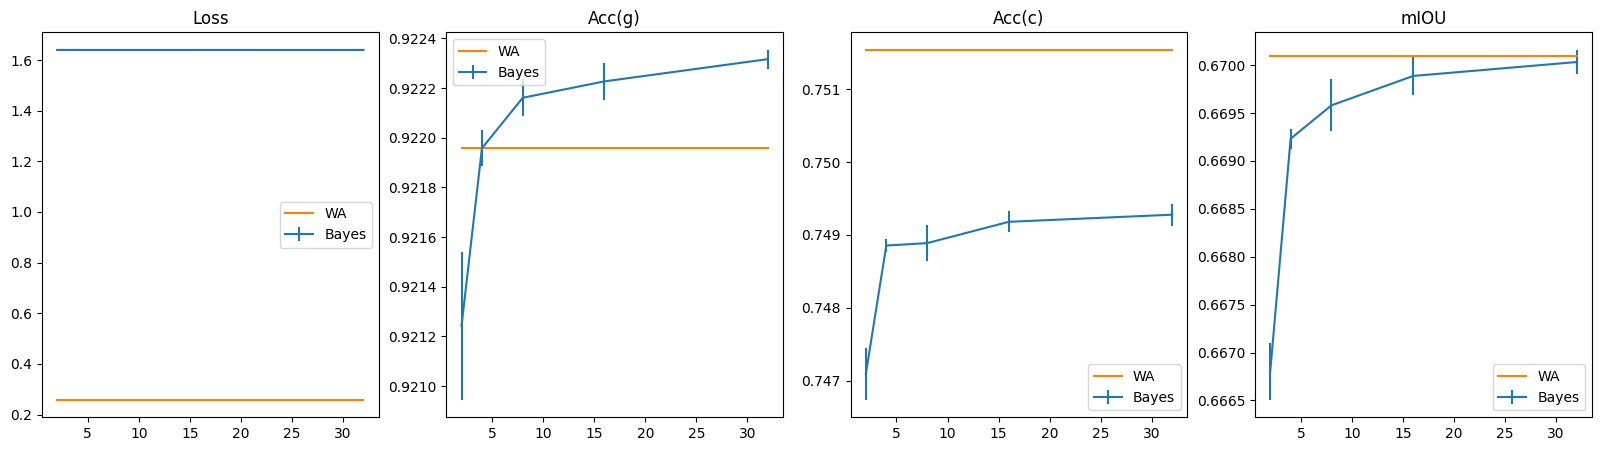

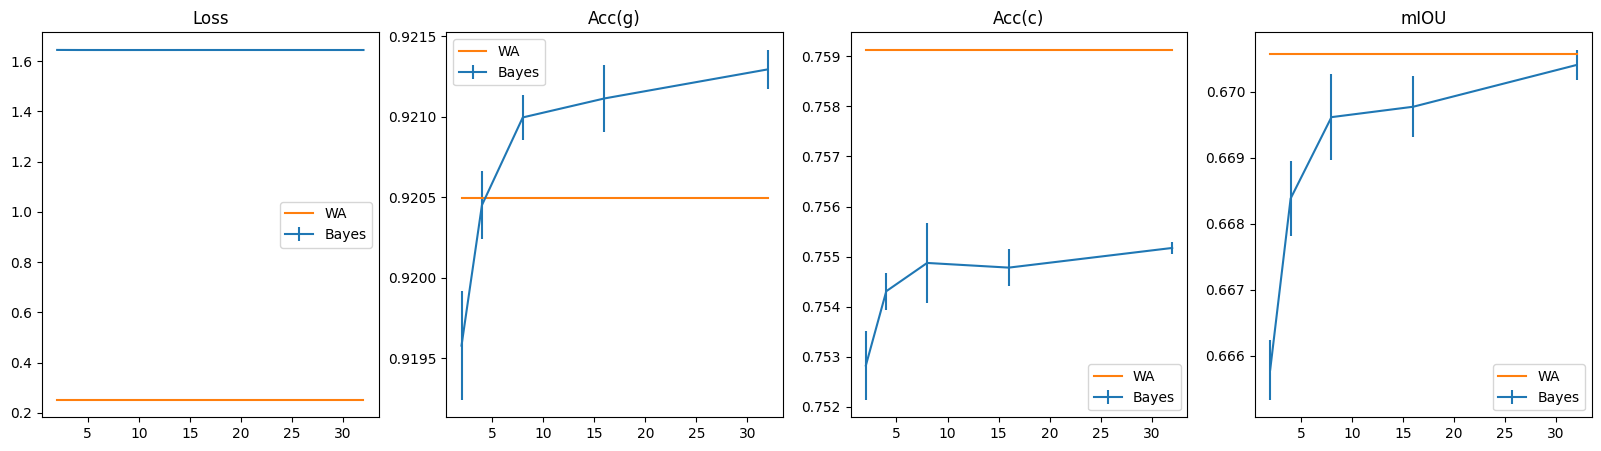

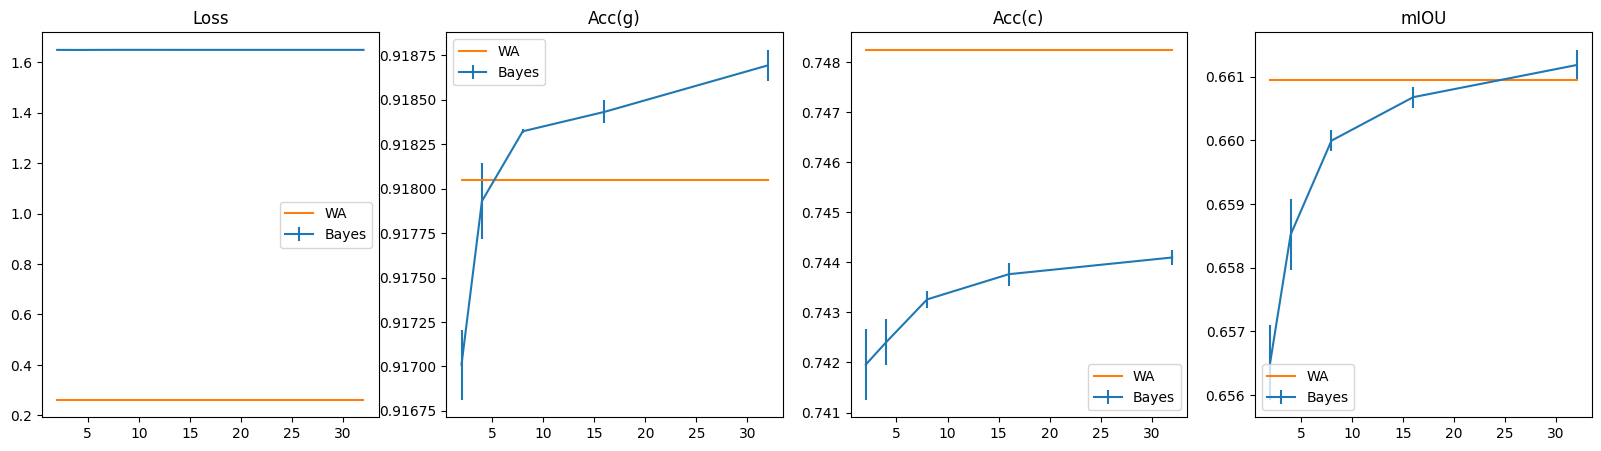

In [98]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['4-sd-0.1', '4-sd-0.3', '4-sd-0.5']

for dir in dirs:
  training_manager.load(f'Thesis/{dir}')
  result_manager = ResultsManager(training_manager)
  result_manager.plot_acc_vs_k(num_repeats=5, ks=[2, 4, 8, 16, 32], save=True)


## Plot Calibration Summary

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/calibration_dropouts.png


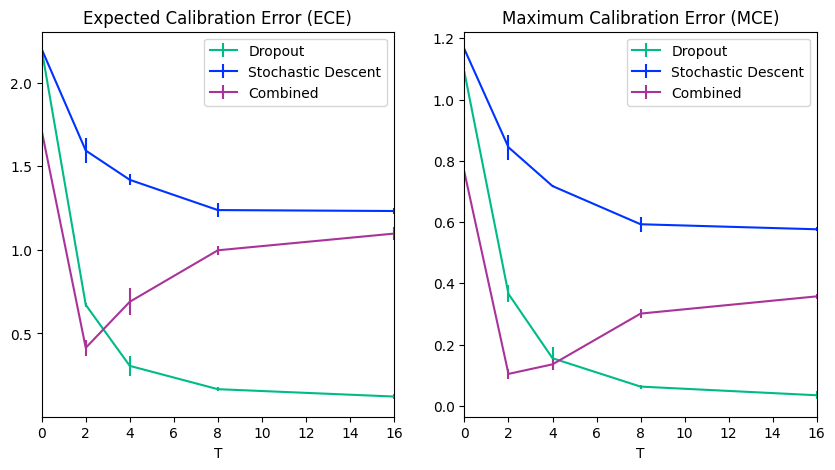

In [ ]:
# initiate empty training_manager
# training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['4-Drop-0.5', '4-sd-0.5', '4-sd-drop-0.5']
# dirs = ['4-sd-0.1', '4-sd-0.3', '4-sd-0.5']
# dirs = ['4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5']
# dirs = ['Baseline', '4-Drop-0.3', '4-Drop-0.5']

names = ['Dropout', 'Stochastic Descent', 'Combined']
ks = [0, 2, 4, 8, 16]

plt.figure(figsize=(10, 5))

clrs = ['#00bb88', '#0033ff', '#aa3399', '#ff6600', '#000000', ]

for i, dir in enumerate(dirs):
  run = runs[dir]

  eces = np.array(run['calibration_full']['ECEs'][:5])*100
  ece_stds = np.array(run['calibration_full']['ECE_stds'][:5])*100
  mces = np.array(run['calibration_full']['MCEs'][:5])*100
  mce_stds = np.array(run['calibration_full']['MCE_stds'][:5])*100

  plt.subplot(1, 2, 1)
  plt.errorbar(ks, eces, yerr=ece_stds, label=names[i], color=clrs[i])

  plt.subplot(1, 2, 2)
  plt.errorbar(ks, mces, yerr=mce_stds, label=names[i], color=clrs[i])

plt.subplot(1, 2, 1)
plt.title('Expected Calibration Error (ECE)')
plt.xlabel('T')
plt.xlim(0, 16)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Maximum Calibration Error (MCE)')
plt.xlabel('T')
plt.xlim(0, 16)
plt.legend(loc='upper right')

# plt.tight_layout()

filename = f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/calibration_dropouts.png"
plt.savefig(filename, dpi=200)
print(f'saved to {filename}')

## Plot Accuracy Summary

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/accuracy_sds.png


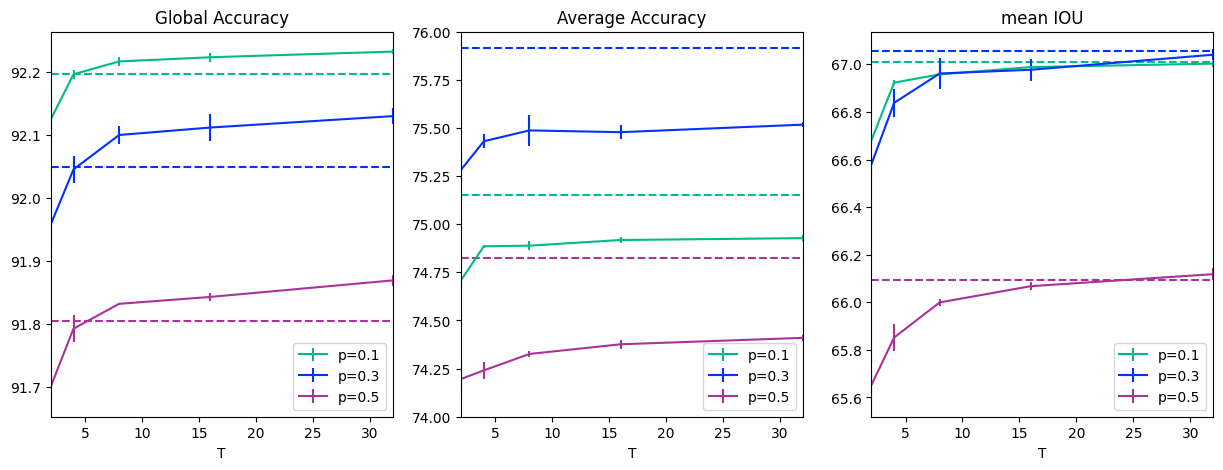

In [106]:
# initiate empty training_manager
# training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

# dirs = ['Baseline', '4-Drop-0.3', '4-Drop-0.5']
dirs = ['4-sd-0.1', '4-sd-0.3', '4-sd-0.5', ]
names = ['p=0.1', 'p=0.3', 'p=0.5']
ks = [2, 4, 8, 16, 32]

plt.figure(figsize=(15, 5))


for i, dir in enumerate(dirs):
  run = runs[dir]
  acc_g, acc_a, miou = [], [], []
  acc_g_std, acc_a_std, miou_std = [], [], []

  acc_g_wa = runs[dir]['ks_vs_metric'][str("0")]['acc_g']*100
  acc_a_wa = runs[dir]['ks_vs_metric'][str("0")]['acc_a']*100
  miou_wa = runs[dir]['ks_vs_metric'][str("0")]['miou']*100
  for k in ks:
    acc_g.append(runs[dir]['ks_vs_metric'][str(k)]['acc_g']*100)
    acc_a.append(runs[dir]['ks_vs_metric'][str(k)]['acc_a']*100)
    miou.append(runs[dir]['ks_vs_metric'][str(k)]['miou']*100)

    acc_g_std.append(runs[dir]['ks_vs_metric'][str(k)]['acc_g_std']*100)
    acc_a_std.append(runs[dir]['ks_vs_metric'][str(k)]['acc_a_std']*100)
    miou_std.append(runs[dir]['ks_vs_metric'][str(k)]['miou_std']*100)

  plt.subplot(1, 3, 1)
  plt.errorbar(ks, acc_g, yerr=acc_g_std, label=names[i], color=clrs[i])
  plt.plot(ks, [acc_g_wa]*len(ks), linestyle='--', color=clrs[i])

  plt.subplot(1, 3, 2)
  plt.errorbar(ks, acc_a, yerr=acc_a_std, label=names[i], color=clrs[i])
  plt.plot(ks, [acc_a_wa]*len(ks), linestyle='--', color=clrs[i])

  plt.subplot(1, 3, 3)
  plt.errorbar(ks, miou, yerr=miou_std, label=names[i], color=clrs[i])
  plt.plot(ks, [miou_wa]*len(ks), linestyle='--', color=clrs[i])


plt.subplot(1, 3, 1)
plt.title('Global Accuracy')
plt.xlabel('T')
plt.xlim(2, 32)
plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.title('Average Accuracy')
plt.xlabel('T')
plt.xlim(2, 32)
plt.ylim(74, 76)
plt.legend(loc='lower right')

plt.subplot(1, 3, 3)
plt.title('mean IOU')
plt.xlabel('T')
plt.xlim(2, 32)
plt.legend(loc='lower right')


# plt.tight_layout()

filename = f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/accuracy_sds.png"
plt.savefig(filename, dpi=200)
print(f'saved to {filename}')

## computation vs calibration error

In [88]:
def _format_memory_mb(mb):
    """Returns a formatted memory size string"""
    KB = 1024
    MB = 1024 * KB
    GB = 1024 * MB
    nbytes = 1024 * 1024 * mb
    if abs(nbytes) >= GB:
        return f"{nbytes * 1.0 / GB:.2f} Gb"
    elif abs(nbytes) >= MB:
        return f"{nbytes * 1.0 / MB:.0f} Mb"
    elif abs(nbytes) >= KB:
        return f"{nbytes * 1.0 / KB:.2f} Kb"
    else:
        return str(nbytes) + " b"

In [ ]:
statistics = {}

training_manager.load(f'Thesis/4-sd-0.3')
result_manager = ResultsManager(training_manager)
net = training_manager.net
dataloader = dataloaders['test']

for t in [0, 2, 4, 8, 16, 32]:
  statistics[t] = {}
  # ----------t, memory-------------
  time, memory = compute_gpu_runtime_memory(net, n=5, k=t)
  statistics[t]['time'] = time.mean()
  statistics[t]['time_std'] = time.std()
  statistics[t]['memory'] = memory.mean()

  # ----------MIOU-------------
  if t == 0:
    loss, acc = training_manager._evaluate_regular(dataloader, net)
  else:
    loss, acc = training_manager._evaluate_bayes(dataloader, k=t, net=net)
  statistics[t]['miou'] = acc['iou/mean']

  # ----------ECE MCE-------------
  total_counts, total_corrects, confs = get_calibration(net, dataloader, k=t, num_buckets=11)

  # compute statistics
  ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
  statistics[t]['ECE'] = float(ECE)
  statistics[t]['MCE'] = float(MCE)

filepath = os.path.join(result_manager.directory, 'compute_vs_calibration.json')
with open(filepath, "w") as f:
  json.dump(statistics, f, indent=2)
print(f"saved network compute_vs_calibration to {filepath}")


In [97]:
ts = [0, 2, 4, 8, 16, 32]
headings = ['Inference', 'Time(ms) $\\downarrow$ ', 'FPS $\\uparrow$', 'Memory $\\downarrow$', 'mIOU $\\uparrow$', 'ECE $\\downarrow$', 'MCE $\\downarrow$']

cells = [['']*len(headings) for _ in range(len(ts))]

for i in range(len(ts)):
  t = ts[i]
  if t == 0:
    name = 'Det.'
  else:
    name = f'T={t}'

  # name
  cells[i][0] = str(name)

  # time
  cells[i][1] = f"{statistics[t]['time']:.1f}$\\pm${statistics[t]['time_std']:.1f}"

  # fps
  time = statistics[t]['time']/1000
  cells[i][2] = f"{1/time:.0f}"

  # Memory(mb)
  cells[i][3] = f"{_format_memory_mb(statistics[t]['memory'])}"

  # mIOU
  cells[i][4] = f"{statistics[t]['miou']*100:.2f}"

  # ECE
  cells[i][5] = f"{statistics[t]['ECE']*100:.2f}"

  # MCE
  cells[i][6] = f"{statistics[t]['MCE']*100:.2f}"

title = "Computational requirements for different Bayesian inference, using \\textit{Sd-0.3}"
print(convert_to_latex(headings,
                       cells,
                       title=title,
                       label='compute_sd',
                       vertical_heading = False))

\begin{table}[ht]
\centering
\caption{Computational requirements for different Bayesian inference, using \textit{Sd-0.3}}
\begin{tabular}{l | c c c c c c }
\label{tab: compute_sd}
Inference & Time(ms) $\downarrow$  & FPS $\uparrow$ & Memory $\downarrow$ & mIOU $\uparrow$ & ECE $\downarrow$ & MCE $\downarrow$\\
\toprule
Det. & 11.4$\pm$0.0 & 88 & 190 Mb & 67.06 & 2.14 & 1.11\\
T=2 & 19.8$\pm$2.3 & 51 & 361 Mb & 66.45 & 1.68 & 0.89\\
T=4 & 33.7$\pm$4.1 & 30 & 712 Mb & 66.90 & 1.37 & 0.69\\
T=8 & 52.4$\pm$0.7 & 19 & 1.39 Gb & 66.94 & 1.30 & 0.65\\
T=16 & 108.7$\pm$0.2 & 9 & 2.77 Gb & 67.01 & 1.25 & 0.60\\
T=32 & 220.4$\pm$0.5 & 5 & 5.54 Gb & 67.03 & 1.22 & 0.58\\
\bottomrule
\end{tabular}
\end{table}


# Other figures

## Reliability Diagram

In [165]:
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

# dirs = ['Baseline-noDrop', 'Baseline', '4-Drop-0.3', '4-Drop-0.5']
dirs = ['Baseline-noDrop', '4-sd-0.1', '4-sd-0.3', '4-sd-0.5']
# dirs = ['Baseline-noDrop', '4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5']

names = ['Deterministic', 'p=0.1', 'p=0.3', 'p=0.5']

nets = []
# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  nets.append(copy.deepcopy(training_manager.net))

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/4 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline-noDrop/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.1/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-sd-0.3/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...


computing calibration for ['Deterministic', 'p=0.1', 'p=0.3', 'p=0.5']


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

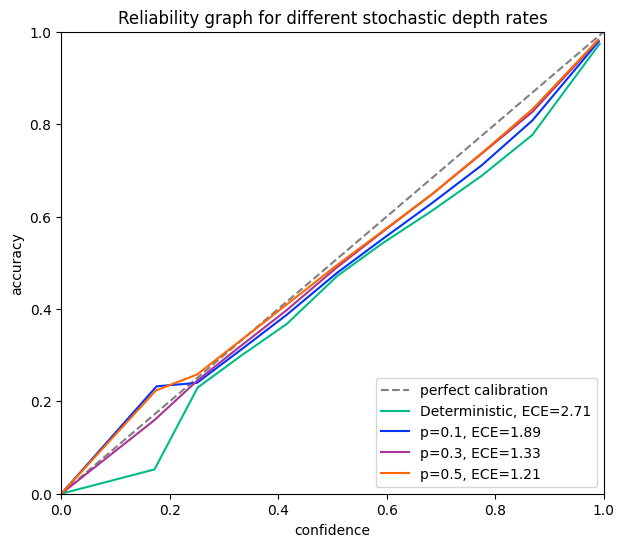

In [166]:
dataloader = training_manager.dataloaders['test']
num_buckets = 11

plt.figure(figsize=(7, 6))

linear_line = np.array(range(num_buckets+1)) / (num_buckets)
plt.plot(linear_line, linear_line, color='grey', zorder=2, linestyle='--', label='perfect calibration')

print(f'computing calibration for {names}')
for i, dir in enumerate(dirs):
  net = nets[i]
  # get the buckets
  total_counts, total_corrects, confs = get_calibration(net, dataloader, k=10, num_buckets=num_buckets)

  # compute statistics
  ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
  # calculate the accuracy of each bucket
  acc = total_corrects / total_counts

  plt.plot(confs, acc, label=f'{names[i]}, ECE={ECE*100:.2f}', color=clrs[i])

plt.title('Reliability graph for different stochastic depth rates')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('confidence')
plt.ylabel('accuracy')

plt.legend(loc='lower right')

plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/reliability_sd.png", dpi=200)

In [ ]:
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['Baseline-noDrop', '4-Drop-0.5']
names = ['Deterministic', 'Dropout-0.5']

nets = []
# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  nets.append(copy.deepcopy(training_manager.net))

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/2 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline-noDrop/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/model.pt
Loading history...
loaded network trained for 200 epochs


In [ ]:
dataloader = training_manager.dataloaders['test']
num_buckets = 11
ks = [0, 10]

plt.figure(figsize=(13, 6))



# DETERMINISTIC
net = nets[0]
# get the buckets
total_counts, total_corrects, det_confs = get_calibration(net, dataloader, k=10, num_buckets=num_buckets)

# calculate the accuracy of each bucket
det_acc = total_corrects / total_counts
det_freq = total_counts/total_counts.sum()

# DETERMINISTIC
net = nets[1]
# get the buckets
total_counts, total_corrects, drop_confs = get_calibration(net, dataloader, k=10, num_buckets=num_buckets)

# calculate the accuracy of each bucket
drop_acc = total_corrects / total_counts
drop_freq = total_counts/total_counts.sum()


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

<Figure size 1300x600 with 0 Axes>

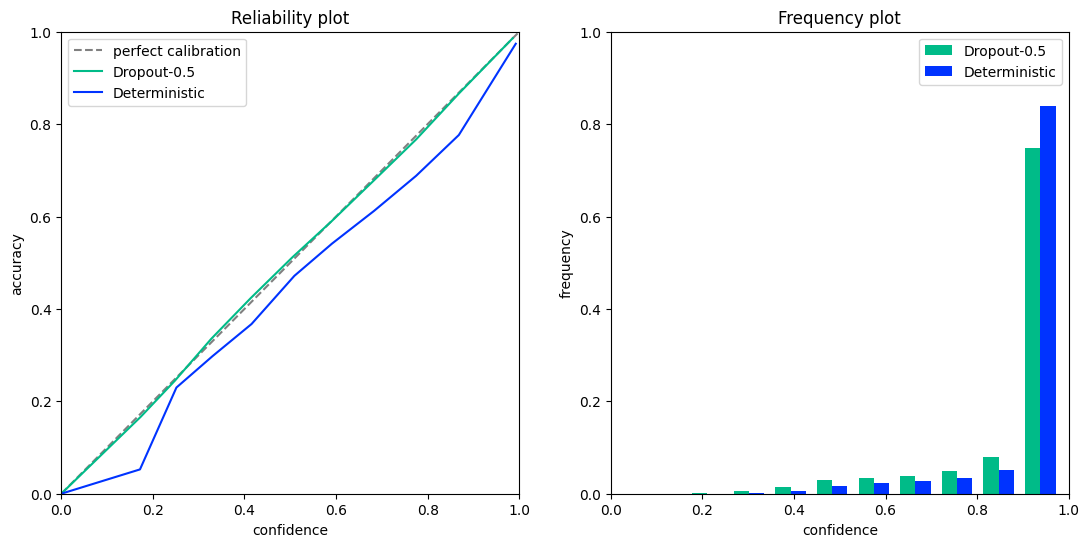

In [ ]:

plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
linear_line = np.array(range(num_buckets+1)) / (num_buckets)
plt.plot(linear_line, linear_line, color='grey', zorder=2, linestyle='--', label='perfect calibration')
plt.plot(drop_confs, drop_acc, label='Dropout-0.5', color=clrs[0])
plt.plot(det_confs, det_acc, label='Deterministic', color=clrs[1])

plt.title('Reliability plot')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Frequency plot')
plt.bar(np.arange(0, 1, 1/11)+1/22-1/30, drop_freq, align='center', label='Dropout-0.5', color=clrs[0], alpha=1, width=1/30)
plt.bar(np.arange(0, 1, 1/11)+1/22, det_freq, align='center', label='Deterministic', color=clrs[1], alpha=1, width=1/30)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('confidence')
plt.ylabel('frequency')
plt.legend()

# plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/reliability_frequency.png", dpi=200)

In [ ]:
np.arange(0, 1, 1/11)

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091])

## Image for Intro

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['Baseline']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/1 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline/model.pt
Loading history...
loaded network trained for 200 epochs


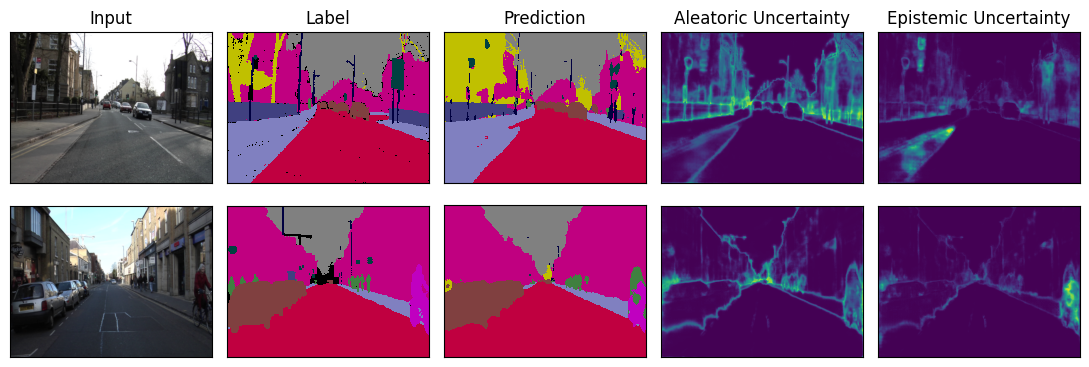

In [ ]:
plt.figure(figsize=(11, 4))
metric = AccuracyMetric()
for (i, id) in enumerate([190, 152]):
  x, y = dataloaders['test'].dataset[id]

  entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k=20)
  miou = metric(y.unsqueeze(0), y_pred.unsqueeze(0))['iou/mean'].item()
  plt.subplot(2, 5, 1+i*5)
  if i == 0:
    plt.title('Input')
  imshow_image(x)

  plt.subplot(2, 5, 2+i*5)
  if i == 0:
    plt.title('Label')
  imshow_label(y)

  plt.subplot(2, 5, 3+i*5)

  # plt.title(f'Pred miou={miou*100:.1f}')
  if i == 0:
    plt.title('Prediction')
  imshow_label(y_pred)

  plt.subplot(2, 5, 4+i*5)
  if i == 0:
    plt.title('Aleatoric Uncertainty')
  imshow_uncertainty(entropy - mutual_info)

  plt.subplot(2, 5, 5+i*5)
  if i == 0:
    plt.title('Epistemic Uncertainty')
  imshow_uncertainty(mutual_info)

plt.tight_layout()

# plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/intro_breakdown.png", dpi=200)

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['0-10M-600e']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/1 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.398 MB
model size: 41.647MB
Total Trainable Params: 10.813M
------------
Training for 600 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-600e/model.pt
Loading history...
loaded network trained for 600 epochs


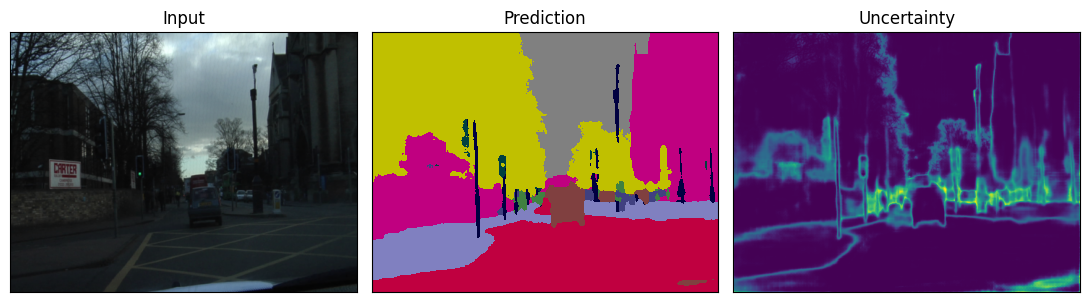

In [ ]:
plt.figure(figsize=(11, 4))
metric = AccuracyMetric()
for (i, id) in enumerate([12]):
  x, y = dataloaders['test'].dataset[id]

  entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k=20)
  miou = metric(y.unsqueeze(0), y_pred.unsqueeze(0))['iou/mean'].item()
  plt.subplot(1, 3, 1+i*5)
  if i == 0:
    plt.title('Input')
  imshow_image(x)

  plt.subplot(1, 3, 2+i*5)
  # plt.title(f'Pred miou={miou*100:.1f}')
  if i == 0:
    plt.title('Prediction')
  imshow_label(y_pred)

  plt.subplot(1, 3, 3+i*5)
  if i == 0:
    plt.title('Uncertainty')
  imshow_uncertainty(entropy)


plt.tight_layout()

plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/intro_uncertainty.png", dpi=200)

## Learning Curves

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['Baseline']

# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  net = copy.deepcopy(training_manager.net)

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/1 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline/model.pt
Loading history...
loaded network trained for 200 epochs


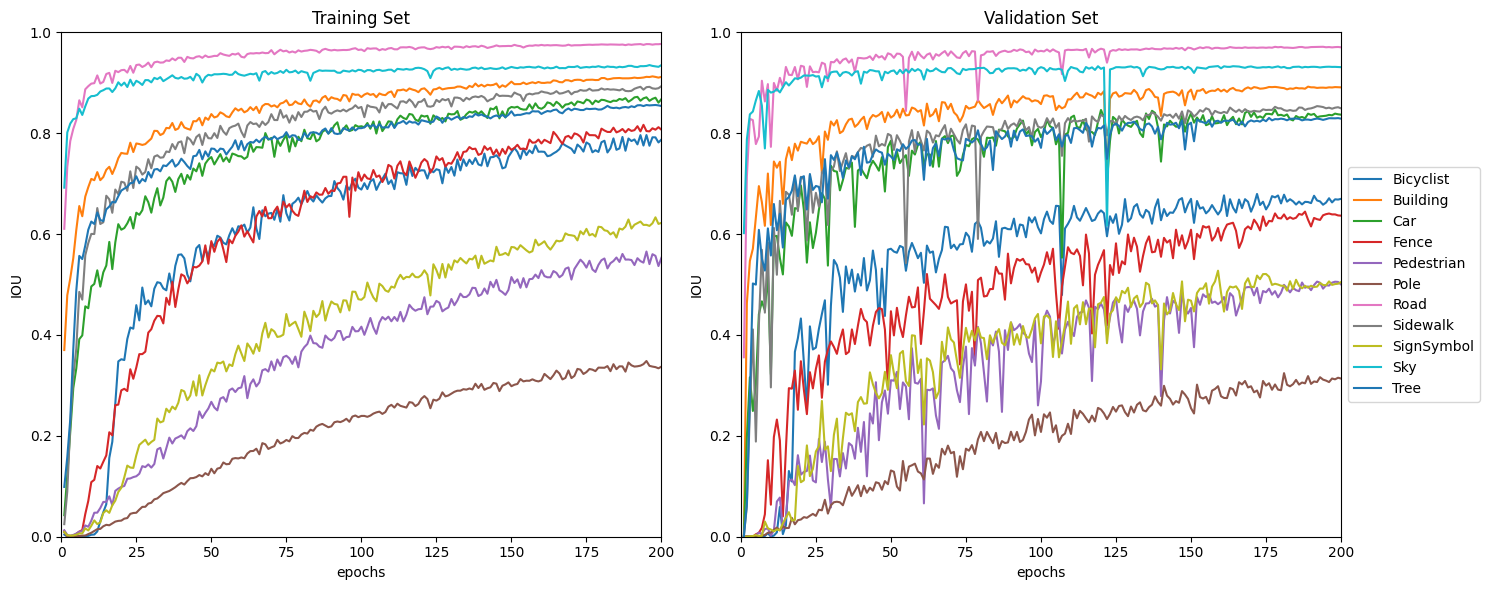

In [10]:

plt.figure(figsize=(15, 6))

# history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
history = runs['6-Baseline']['history']

x = list(range(1, 201, 1))

plt.subplot(1, 2, 1)
plt.title('Training Set')
for i, c in CLASS_MAP.items():
  plt.plot(x, history[f'iou/{c}/train'], label=f'{c}',)
plt.ylabel('IOU')
plt.xlabel('epochs')
plt.ylim(0, 1)
plt.xlim(0, 200)

plt.subplot(1, 2, 2)
plt.title('Validation Set')
for i, c in CLASS_MAP.items():
  plt.plot(x, history[f'iou/{c}/val'], label=f'{c}',)
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.ylabel('IOU')
plt.xlabel('epochs')
plt.legend(fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/baseline_history.png", dpi=200)

## Trade-off curve

mIOU vs parameters

In [74]:
data = {
  "FCN8": [134.5, 57.0, 0.2, 0.5],
  "DeconvNet": [252.0, 48.9, 0.2, 0.5],
  "SegNet": [29.5, 46.4, 0.2, 0.5],
  "ENet": [0.37, 51.3, 0.2, 0.5],
  "Lite": [0.56, 66.4, 0.4, 0.2],
  "Medium": [2.7, 71.6, -2, 0.5],
  "Large": [10.52, 73.9, 0.2, 0.5],
  "FCDenseNet56": [1.5, 58.9, 0.5, 0],
  "FCDenseNet67": [3.5, 65.8, -0.5, 1.5],
  "FCDenseNet103": [9.4, 66.9, 0.2, 0.5],
  "BiSeNet (Xception)": [5.8, 65.6, 0.2, -1.5],
  "BiSeNet (ResNet18)": [49.0, 68.7, -7.5, 0.5],
  "DDRNet23-Slim": [5.7, 74.7, -1, 1],
  "DDRNet23": [20.1, 76.3, 0.2, 0.5],
  "RTFormer-Slim": [4.8, 81.5, 0.2, 0.5],
  "RTFormer": [16.8, 82.5, 0.2, 0.5]
}

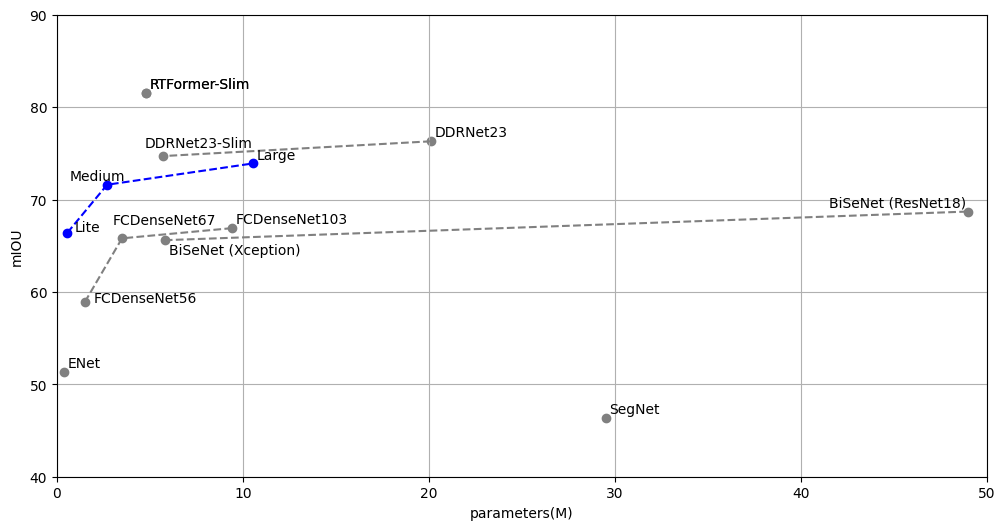

In [77]:
plt.figure(figsize=(12, 6))
plt.grid('on')

def get_annotation_pos(name):
  return data[name][0]+data[name][2], data[name][1]+data[name][3]

# our methods:
line_x, line_y = [], []
for name in ['Lite', 'Medium', 'Large']:
  plt.scatter(data[name][0], data[name][1], color='blue')
  plt.annotate(name, get_annotation_pos(name))
  line_x.append(data[name][0])
  line_y.append(data[name][1])

plt.plot(line_x, line_y, color='blue', linestyle='--')

for name in ['FCN8', 'DeconvNet', 'SegNet', 'ENet', 'RTFormer-Slim', 'RTFormer-Slim']:
  plt.scatter(data[name][0], data[name][1], color='gray')
  plt.annotate(name, get_annotation_pos(name))

line_x, line_y = [], []
for name in ['DDRNet23', 'DDRNet23-Slim']:
  plt.scatter(data[name][0], data[name][1], color='gray')
  plt.annotate(name, get_annotation_pos(name))
  line_x.append(data[name][0])
  line_y.append(data[name][1])

plt.plot(line_x, line_y, color='gray', linestyle='--')

line_x, line_y = [], []
for name in ['FCDenseNet56', 'FCDenseNet67', 'FCDenseNet103']:
  plt.scatter(data[name][0], data[name][1], color='grey')
  plt.annotate(name, get_annotation_pos(name))
  line_x.append(data[name][0])
  line_y.append(data[name][1])

plt.plot(line_x, line_y, color='grey', linestyle='--')

line_x, line_y = [], []
for name in ['BiSeNet (Xception)', 'BiSeNet (ResNet18)', ]:
  plt.scatter(data[name][0], data[name][1], color='grey')
  plt.annotate(name, get_annotation_pos(name))
  line_x.append(data[name][0])
  line_y.append(data[name][1])

plt.plot(line_x, line_y, color='grey', linestyle='--')

plt.xlim(0, 50)
plt.ylim(40, 90)

plt.xlabel('parameters(M)')
plt.ylabel('mIOU')

# plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/sota_compare.png", dpi=200)


## Out of distribution data

In [101]:
training_manager = TrainingManager(dataset_manager.datasets, dummy_cfg)

dirs = ['Baseline-noDrop', '4-Drop-0.5']
names = ['Deterministic', 'Dropout-0.5']

nets = []
# copy the networks
for dir in tqdm(dirs):
  training_manager.load(f'Thesis/{dir}')
  nets.append(copy.deepcopy(training_manager.net))

----UNET----
Buffer size: 0.059 MB
model size: 2.093MB
Total Trainable Params: 0.533M
------------
Training for 100 iterations


  0%|          | 0/2 [00:00<?, ?it/s]

Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline-noDrop/model.pt
Loading history...
loaded network trained for 200 epochs
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/model.pt
Loading history...
loaded network trained for 200 epochs


In [139]:
def get_calibration_per_prediction_mi(y_gt, y_prob, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x W x H)
  y_softmax: torch.tensor (c x W x H)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, ) counts in each bin
  correct: np.array (num_buckets, ) number of corrects in each bin
  conf: np.array (num_buckets, ) the average confidence p
  '''
  mask = (y_gt!=FILL_PIX).to(float)
  out_count = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  out_correct = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  out_conf = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  step = 1/num_buckets
  # get probability and prediction
  indices = y_prob // step
  y_pred = torch.ones_like(y_gt)

  for i in range(num_buckets):
    idx_mask = mask*(indices==i)
    out_count[i] = (idx_mask).sum()
    out_correct[i] = (idx_mask*(y_pred==y_gt)).sum()
    out_conf[i] = (idx_mask*y_prob).sum().item()
  return out_count, out_correct, out_conf


def get_mi_buckets(net:nn.Module,
                    dataloader:DataLoader,
                    k:int,
                    mode: Optional[str]='all',
                    num_buckets:Optional[int]=10
):
  '''
  Returns array of buckets for the reliability plot

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  mode: sets the mode of which bayesian inference to perform
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  Returns
  -----------
  total_counts: (num_buckets, ) np array, number of instances with confidence in the bucket
  total_corrects: (num_buckets, ) np array, number of correct instances with confidence in the bucket
  total_confs: (num_buckets, ) np array, the confidence score for each bucket by the network
  '''
  total_counts = np.array([1e-16]*num_buckets, dtype=np.float32)
  total_corrects = np.array([0]*num_buckets, dtype=np.float32)
  total_confs = np.array([0]*num_buckets, dtype=np.float32)

  # loop through images and make predictions
  for X_batch, y_batch in tqdm(dataloader):
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
        elif k > 0:
          net.set_bayes_mode(True, mode)
          # y_softmax, _, _, _ = bayes_forward(net, x, k)
          entropy, mi, y_pred = compute_bayesian_uncertainties(net, x, k, mode='all')


        counts, corrects, conf = get_calibration_per_prediction_mi(y, mi, num_buckets)
        total_counts += counts
        total_corrects += corrects
        total_confs += conf

  # buckets = total_corrects / total_counts

  return total_counts, total_corrects, total_confs/total_counts

In [140]:
dataloader = training_manager.dataloaders['test']
dataloader_ood = dataloaders['ood']
num_buckets = 10
ks = [0, 10]

plt.figure(figsize=(13, 6))

# calculate the accuracy of each bucket
det_acc_ood = total_corrects / total_counts
det_freq_ood = total_counts/total_counts.sum()

# WITH BAYESIAN
net = nets[0]
# get the buckets
total_counts, total_corrects, drop_confs = get_mi_buckets(net, dataloader, k=10, num_buckets=num_buckets)

# calculate the accuracy of each bucket
mi_drop_acc = total_corrects / total_counts
mi_drop_freq = total_counts/total_counts.sum()

net = nets[1]
# get the buckets
total_counts, total_corrects, drop_confs = get_mi_buckets(net, dataloader_ood, k=10, num_buckets=num_buckets)

# calculate the accuracy of each bucket
mi_drop_acc_ood = total_corrects / total_counts
mi_drop_freq_ood = total_counts/total_counts.sum()


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

<Figure size 1300x600 with 0 Axes>

In [ ]:
b = num_buckets
plt.figure(figsize=(6, 6))

plt.title('Dropout Network (Mutual Info)')
plt.bar(np.arange(0, 1, 1/b)+1/(2*b), mi_drop_freq, align='center', label='CamVid', color=clrs[2], alpha=1.0, width=1/(3*b))
plt.bar(np.arange(0, 1, 1/b)+1/(2*b)-1/(3*b), mi_drop_freq_ood, align='center', label='RUGD', color=clrs[3], alpha=1.0, width=1/(3*b))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('confidence')
plt.ylabel('frequency')
plt.legend()

In [119]:
dataloader = training_manager.dataloaders['test']
dataloader_ood = dataloaders['ood']
num_buckets = 10
ks = [0, 10]

plt.figure(figsize=(13, 6))

# DETERMINISTIC
net = nets[0]
# get the buckets
total_counts, total_corrects, det_confs = get_calibration(net, dataloader, k=0, num_buckets=num_buckets)

# calculate the accuracy of each bucket
det_acc = total_corrects / total_counts
det_freq = total_counts/total_counts.sum()

# DETERMINISTIC - OOD
net = nets[0]
# get the buckets
total_counts, total_corrects, det_confs = get_calibration(net, dataloader_ood, k=0, num_buckets=num_buckets)

# calculate the accuracy of each bucket
det_acc_ood = total_corrects / total_counts
det_freq_ood = total_counts/total_counts.sum()

# WITH BAYESIAN
net = nets[1]
# get the buckets
total_counts, total_corrects, drop_confs = get_calibration(net, dataloader, k=10, num_buckets=num_buckets)

# calculate the accuracy of each bucket
drop_acc = total_corrects / total_counts
drop_freq = total_counts/total_counts.sum()

net = nets[1]
# get the buckets
total_counts, total_corrects, drop_confs = get_calibration(net, dataloader_ood, k=10, num_buckets=num_buckets)

# calculate the accuracy of each bucket
drop_acc_ood = total_corrects / total_counts
drop_freq_ood = total_counts/total_counts.sum()


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

<Figure size 1300x600 with 0 Axes>

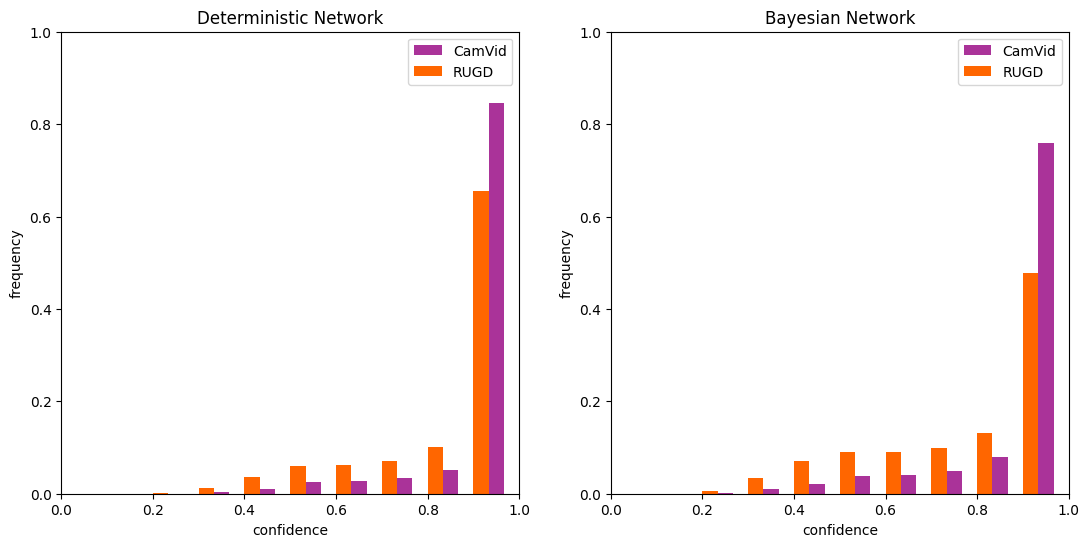

In [129]:
b = num_buckets
plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
plt.title('Deterministic Network')
plt.bar(np.arange(0, 1, 1/b)+1/(2*b), det_freq, align='center', label='CamVid', color=clrs[2], alpha=1.0, width=1/(3*b))
plt.bar(np.arange(0, 1, 1/b)+1/(2*b)-1/(3*b), det_freq_ood, align='center', label='RUGD', color=clrs[3], alpha=1.0, width=1/(3*b))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('confidence')
plt.ylabel('frequency')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Bayesian Network')
plt.bar(np.arange(0, 1, 1/b)+1/(2*b), drop_freq, align='center', label='CamVid', color=clrs[2], alpha=1.0, width=1/(3*b))
plt.bar(np.arange(0, 1, 1/b)+1/(2*b)-1/(3*b), drop_freq_ood, align='center', label='RUGD', color=clrs[3], alpha=1.0, width=1/(3*b))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('confidence')
plt.ylabel('frequency')
plt.legend()

plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/ood_distribution.png", dpi=200)

In [151]:
net = nets[1]
k = 10
indices = [15, 21, 9, 6] # 14: road, 15: rocky
# indices = [20, 21, 22, 11]

plt.figure(figsize=(15, 10))

with torch.no_grad():
  xs, ys = dataloaders['ood'].dataset[indices]
  for i in range(len(indices)):
    # x, y = next(iter(dataloaders['val']))
    x, y = xs[i], ys[i]
    # y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)
    entropy, mi, y_pred = compute_bayesian_uncertainties(net, x, k, mode='all')

    # net.set_bayes_mode(False, 'all')
    # y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
    plt.subplot(4, 5, i*5+1)
    imshow_image(x)
    plt.axis('off')
    if i == 0:
      plt.title('Input Image')

    plt.subplot(4, 5, i*5+2)
    imshow_label(y_pred)
    plt.axis('off')
    if i == 0:
      plt.title(f'Prediction')

    plt.subplot(4, 5, i*5+3)
    imshow_uncertainty((entropy-mi).cpu())
    plt.axis('off')
    if i == 0:
      plt.title(f'Aleatoric Uncertainty (PE-MI)')

    plt.subplot(4, 5, i*5+4)
    imshow_uncertainty(mi.cpu())
    plt.axis('off')
    if i == 0:
      plt.title(f'Epistemic Uncertainty (MI)')

    plt.subplot(4, 5, i*5+5)
    imshow_uncertainty(entropy.cpu())
    plt.axis('off')
    if i == 0:
      plt.title(f'Predictive Uncertainty (PE)')

  plt.tight_layout()

plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/ood_qualitative.png", dpi=200)

Output hidden; open in https://colab.research.google.com to view.

## Qualitative, best network

In [153]:
training_manager.load('Thesis/5-Large-expLR')

Loading config...
----UNET----
Buffer size: 0.320 MB
model size: 40.453MB
Total Trainable Params: 10.521M
------------
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/5-Large-expLR/model.pt
Loading history...
loaded network trained for 721 epochs


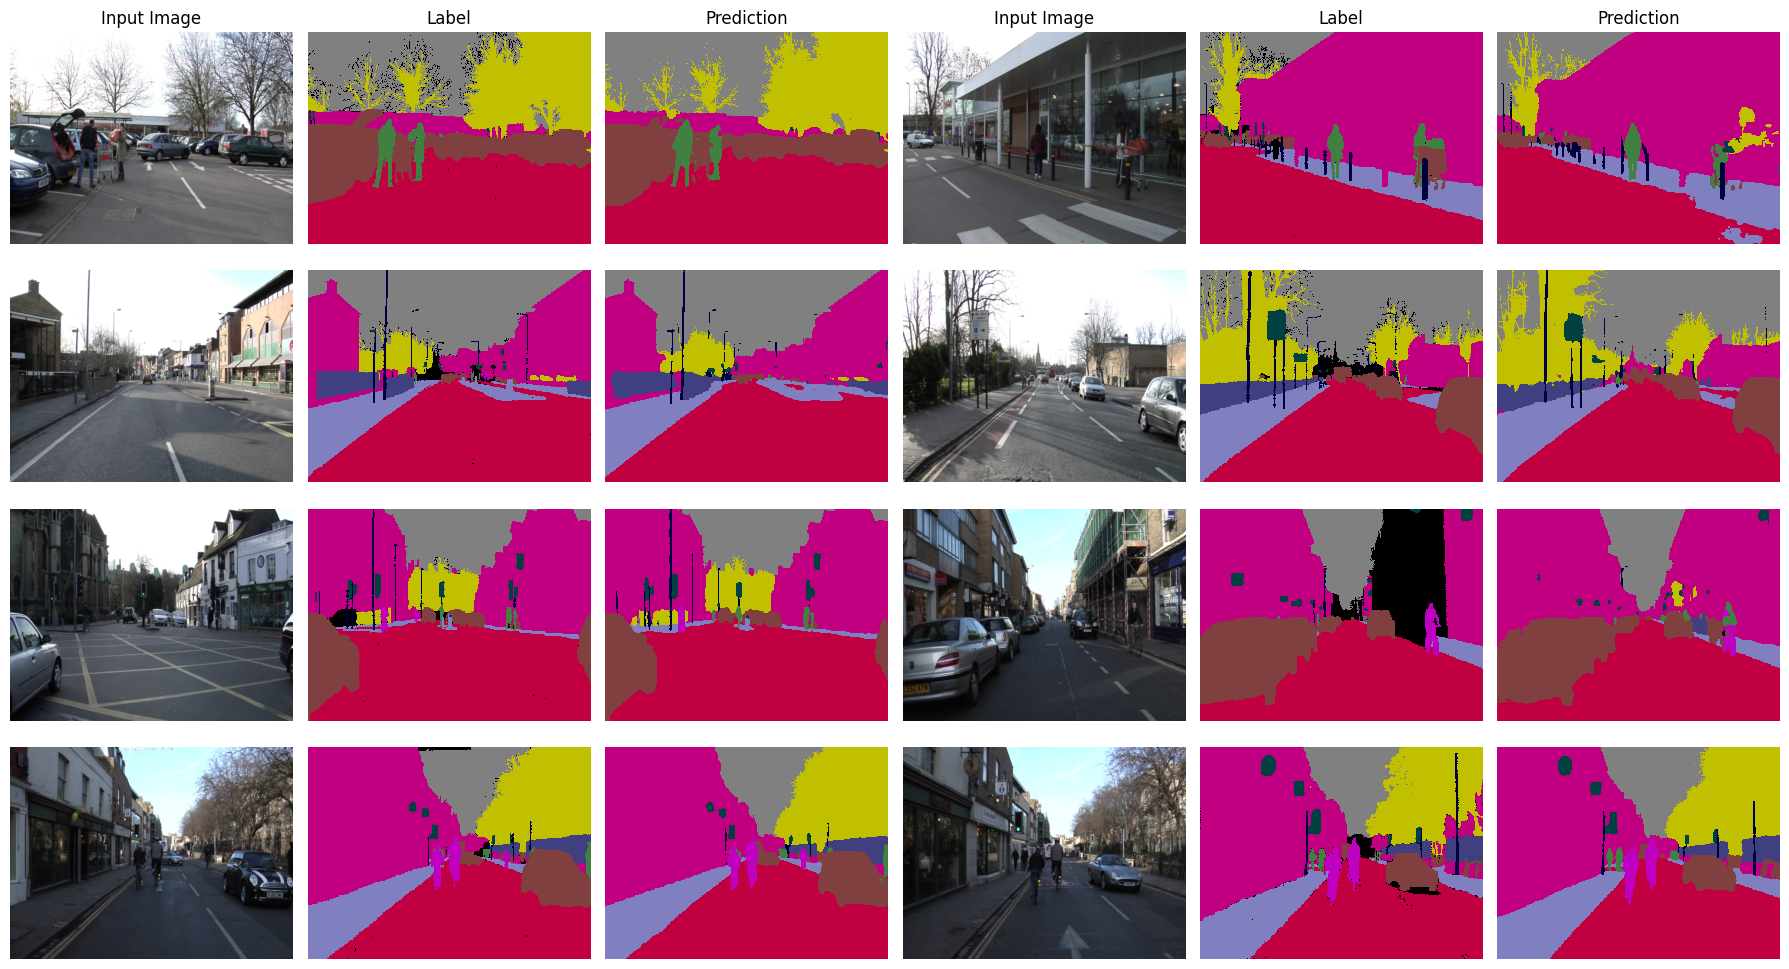

In [157]:
net = training_manager.net
k = 10
indices = [0, 10, 20, 30, 40, 50, 60, 70]
indices = [100, 110, 120, 130, 140, 150, 160, 170]

plt.figure(figsize=(18, 10))

j = 0
with torch.no_grad():
  xs, ys = dataloaders['test'].dataset[indices]
  for i in range(len(indices)):
    # x, y = next(iter(dataloaders['val']))
    x, y = xs[i], ys[i]
    # y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)
    entropy, mi, y_pred = compute_bayesian_uncertainties(net, x, k, mode='all')

    # net.set_bayes_mode(False, 'all')
    # y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
    plt.subplot(4, 6, j+1)
    imshow_image(x)
    plt.axis('off')
    if i == 0 or i == 1:
      plt.title('Input Image')

    plt.subplot(4, 6, j+2)
    imshow_label(y)
    plt.axis('off')
    if i == 0 or i == 1:
      plt.title(f'Label')

    plt.subplot(4, 6, j+3)
    imshow_label(y_pred)
    plt.axis('off')
    if i == 0 or i == 1:
      plt.title(f'Prediction')

    j += 3

  plt.tight_layout()

# plt.savefig(f"/content/drive/MyDrive/ShorelineNet_pytorch/results/qualitative/best_qualitative_2.png", dpi=200)